# BenchFS Performance Analysis

This notebook provides comprehensive analysis of BenchFS benchmark results, combining:
1. **io_uring io_depth Analysis** - Batching efficiency
2. **I/O Timing Analysis** - Disk I/O latency and bandwidth
3. **Node Transfer Analysis** - Load distribution across nodes

## Data Sources
- `io_depth_raw.csv`: Raw per-submit io_depth data
- `io_timing_raw.csv`: Raw per-I/O operation data
- `node_transfer_aggregated.csv`: Aggregated transfer data per second

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from datetime import datetime
import re

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Configure plot sizes
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12

In [42]:
# ============================================================
# Configuration - Update this path to your results directory
# ============================================================
RESULTS_DIR = Path('/work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.01.24-22.49.26-debug_large/2026.01.24-22.56.47-541890.nqsv-16')

print(f"Results directory: {RESULTS_DIR}")
print(f"Directory exists: {RESULTS_DIR.exists()}")

Results directory: /work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.01.24-22.49.26-debug_large/2026.01.24-22.56.47-541890.nqsv-16
Directory exists: True


In [43]:
# ============================================================
# Helper Functions
# ============================================================

def parse_timestamp(ts_str):
    """Parse ISO timestamp string to datetime."""
    try:
        ts_str = ts_str.replace('Z', '+00:00')
        return datetime.fromisoformat(ts_str)
    except:
        return None

def clean_node_name(node_str):
    """Extract 'bnodeXXX' from potentially corrupted strings."""
    node_pattern = re.compile(r'(bnode\d+)')
    match = node_pattern.search(str(node_str))
    return match.group(1) if match else node_str

def load_csv_if_exists(csv_path, name):
    """Load CSV file if it exists, return None otherwise."""
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        print(f"Loaded {name}: {len(df):,} records")
        return df
    else:
        print(f"{name} not found at {csv_path}")
        return None

---
# Part 1: io_uring io_depth Analysis

Analyzes io_uring batching efficiency. Low io_depth indicates suboptimal batching.

## Key Metrics
- **io_depth**: Number of SQEs in the submission queue at submit time
- **sqe_count**: Number of SQEs submitted in this batch
- Lower io_depth indicates suboptimal io_uring batching

In [44]:
# Load io_depth data
df_iodepth = load_csv_if_exists(RESULTS_DIR / 'io_depth_raw.csv', 'io_depth_raw.csv')

if df_iodepth is not None:
    df_iodepth['datetime'] = df_iodepth['timestamp'].apply(parse_timestamp)
    df_iodepth = df_iodepth.dropna(subset=['datetime'])
    
    start_time = df_iodepth['datetime'].min()
    df_iodepth['time_relative'] = (df_iodepth['datetime'] - start_time).dt.total_seconds()
    df_iodepth['time_bucket'] = (df_iodepth['time_relative'] // 1).astype(int)
    
    print(f"\nTime range: {df_iodepth['datetime'].min()} - {df_iodepth['datetime'].max()}")
    print(f"Duration: {df_iodepth['time_relative'].max():.1f} seconds")
    print(f"Nodes: {sorted(df_iodepth['node'].unique())}")
    print(f"\nio_depth statistics:")
    print(f"  Mean: {df_iodepth['io_depth'].mean():.2f}")
    print(f"  Median: {df_iodepth['io_depth'].median():.2f}")
    print(f"  Min: {df_iodepth['io_depth'].min()}, Max: {df_iodepth['io_depth'].max()}")

Loaded io_depth_raw.csv: 2,333 records

Time range: 2026-01-24 13:59:28.523236+00:00 - 2026-01-24 14:03:33.213088+00:00
Duration: 244.7 seconds
Nodes: ['bnode053', 'bnode054', 'bnode055', 'bnode056', 'bnode058', 'bnode059', 'bnode060', 'bnode061', 'bnode063', 'bnode107', 'bnode108', 'bnode110', 'bnode116', 'bnode117', 'bnode118', 'bnode119']

io_depth statistics:
  Mean: 15.06
  Median: 2.00
  Min: 1, Max: 553


## 1.1 io_depth Distribution Overview

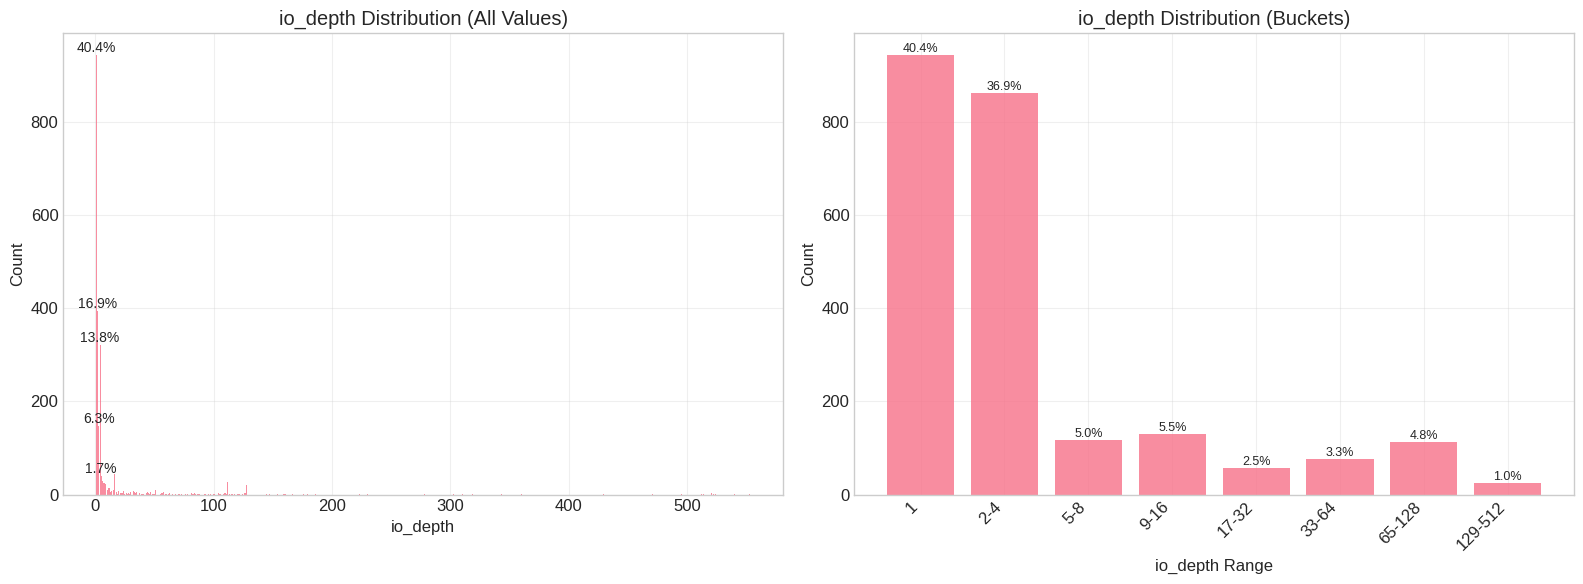

In [45]:
# io_depth distribution
if df_iodepth is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    total = len(df_iodepth)

    # Full distribution
    ax = axes[0]
    depth_counts = df_iodepth['io_depth'].value_counts().sort_index()
    ax.bar(depth_counts.index, depth_counts.values, alpha=0.8)
    ax.set_xlabel('io_depth')
    ax.set_ylabel('Count')
    ax.set_title('io_depth Distribution (All Values)')
    ax.grid(True, alpha=0.3)
    
    # Add percentage labels for top values
    for depth in depth_counts.head(5).index:
        count = depth_counts[depth]
        pct = count / total * 100
        ax.annotate(f'{pct:.1f}%', xy=(depth, count), ha='center', va='bottom', fontsize=10)

    # Bucketed distribution
    ax = axes[1]
    buckets = [(1, 1), (2, 4), (5, 8), (9, 16), (17, 32), (33, 64), (65, 128), (129, 512)]
    bucket_labels = ['1', '2-4', '5-8', '9-16', '17-32', '33-64', '65-128', '129-512']
    bucket_counts = [len(df_iodepth[(df_iodepth['io_depth'] >= lo) & (df_iodepth['io_depth'] <= hi)]) for lo, hi in buckets]

    bars = ax.bar(range(len(bucket_labels)), bucket_counts, alpha=0.8)
    ax.set_xticks(range(len(bucket_labels)))
    ax.set_xticklabels(bucket_labels, rotation=45, ha='right')
    ax.set_xlabel('io_depth Range')
    ax.set_ylabel('Count')
    ax.set_title('io_depth Distribution (Buckets)')
    ax.grid(True, alpha=0.3)

    for i, (bar, count) in enumerate(zip(bars, bucket_counts)):
        pct = count / total * 100
        ax.annotate(f'{pct:.1f}%', xy=(i, count), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_depth_distribution.png', dpi=150)
    plt.show()
    
    # Print warning if mostly io_depth=1
    depth_1_pct = len(df_iodepth[df_iodepth['io_depth'] == 1]) / total * 100
    if depth_1_pct > 50:
        print(f"\n*** WARNING: {depth_1_pct:.1f}% of submits have io_depth=1 ***")
        print("io_uring batching is highly inefficient!")

## 1.2 io_depth Over Time

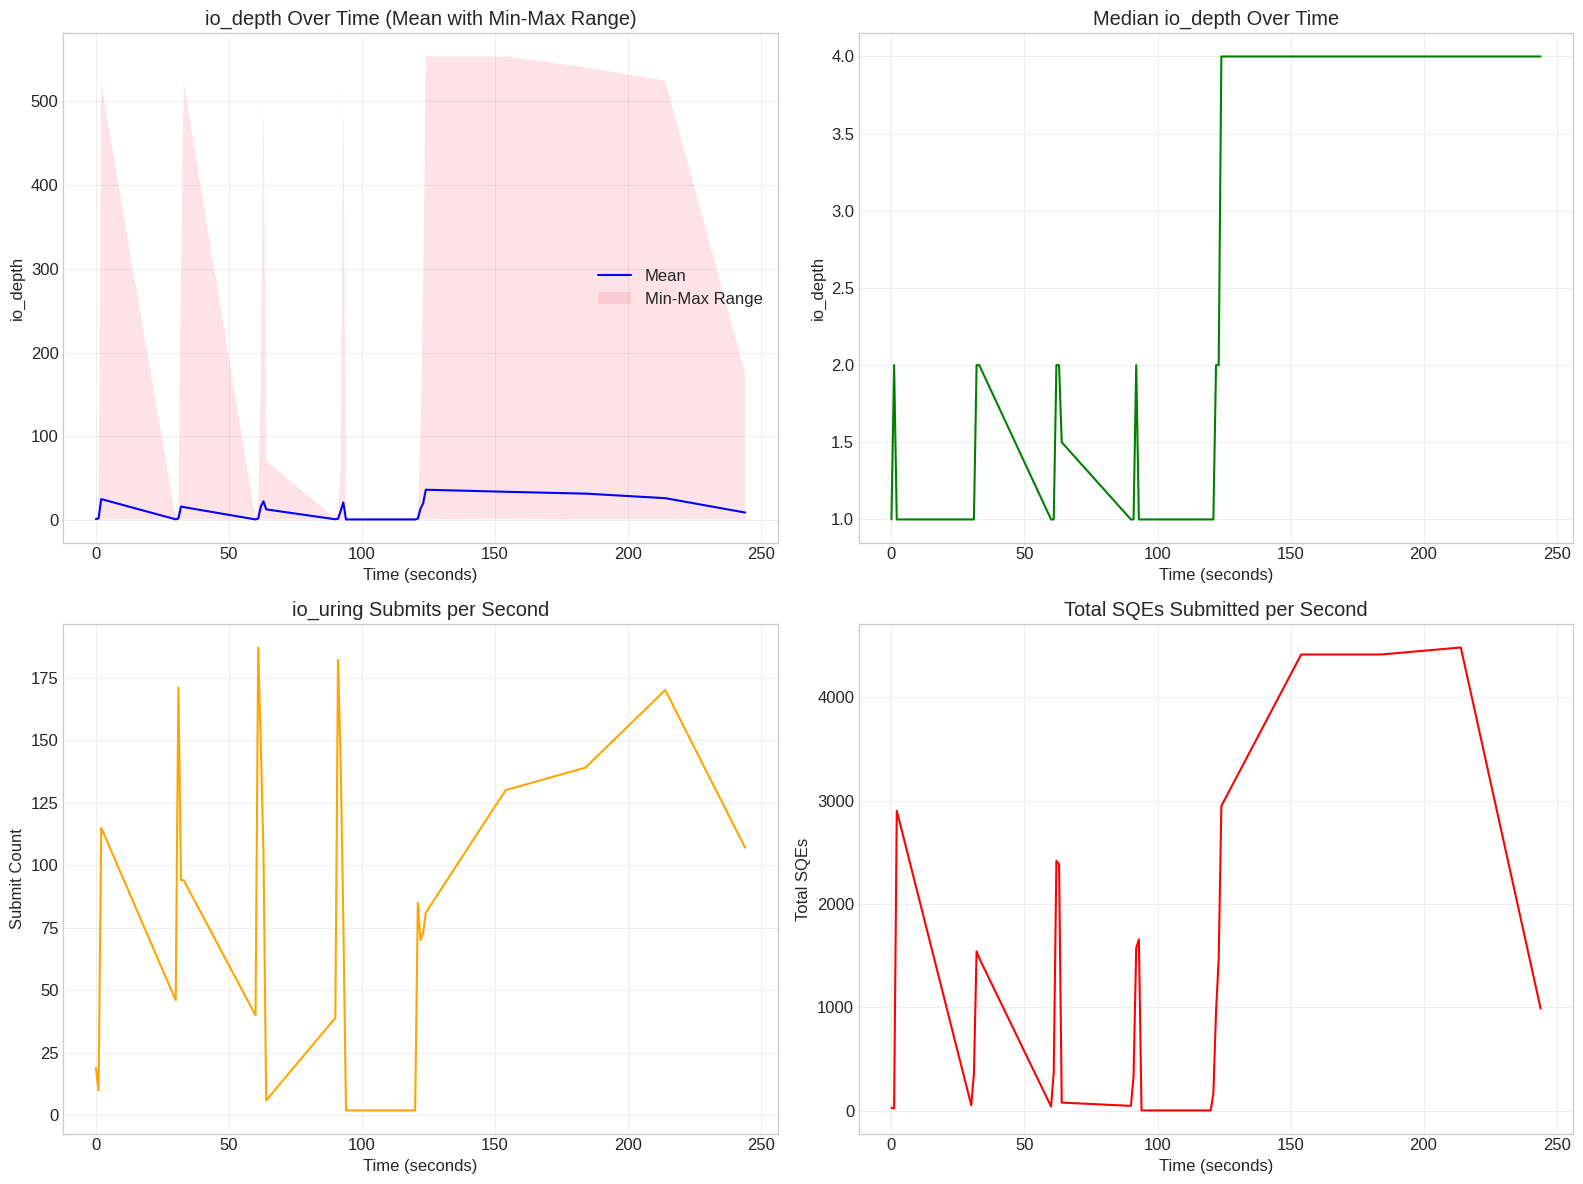

In [46]:
# io_depth over time
if df_iodepth is not None:
    time_stats = df_iodepth.groupby('time_bucket').agg({
        'io_depth': ['mean', 'median', 'min', 'max', 'std', 'count'],
        'sqe_count': 'sum'
    }).reset_index()
    time_stats.columns = ['time', 'mean', 'median', 'min', 'max', 'std', 'submit_count', 'total_sqes']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    ax = axes[0, 0]
    ax.plot(time_stats['time'], time_stats['mean'], linewidth=1.5, label='Mean', color='blue')
    ax.fill_between(time_stats['time'], time_stats['min'], time_stats['max'], alpha=0.2, label='Min-Max Range')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('io_depth')
    ax.set_title('io_depth Over Time (Mean with Min-Max Range)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[0, 1]
    ax.plot(time_stats['time'], time_stats['median'], linewidth=1.5, color='green')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('io_depth')
    ax.set_title('Median io_depth Over Time')
    ax.grid(True, alpha=0.3)

    ax = axes[1, 0]
    ax.plot(time_stats['time'], time_stats['submit_count'], linewidth=1.5, color='orange')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Submit Count')
    ax.set_title('io_uring Submits per Second')
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    ax.plot(time_stats['time'], time_stats['total_sqes'], linewidth=1.5, color='red')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Total SQEs')
    ax.set_title('Total SQEs Submitted per Second')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_depth_over_time.png', dpi=150)
    plt.show()

## 1.3 Per-Node io_depth Analysis

Per-Node io_depth Statistics:
    node      mean  median  min  max       std  submit_count  total_sqes
bnode053  1.096774     1.0    1    2  0.300537            31          34
bnode054 12.368564     2.0    1  343 35.154313           369        4564
bnode055 16.422907     3.0    1  524 56.541762           227        3728
bnode056  1.674419     1.0    1    6  1.269014            86         144
bnode058  1.636364     1.0    1    5  1.245086            77         126
bnode059  1.280000     1.0    1    6  0.926701            50          64
bnode060  1.000000     1.0    1    1  0.000000            18          18
bnode061  1.200000     1.0    1    2  0.447214             5           6
bnode063  1.000000     1.0    1    1  0.000000             4           4
bnode107 22.240602     2.0    1  553 71.809212           133        2958
bnode108 27.568075     3.0    1  553 74.298869           213        5872
bnode110 15.420290     2.0    1  521 42.760783           276        4256
bnode116  1.000000   

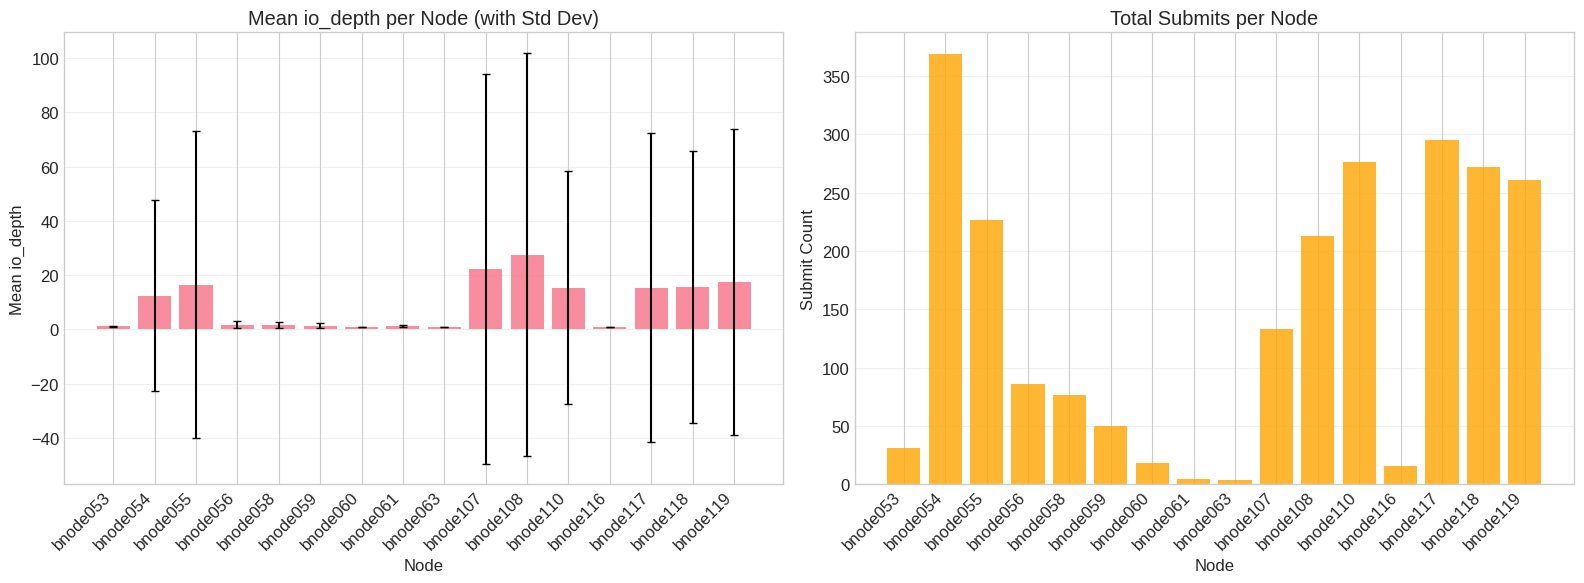

In [47]:
# Per-node io_depth statistics
if df_iodepth is not None:
    node_stats = df_iodepth.groupby('node').agg({
        'io_depth': ['mean', 'median', 'min', 'max', 'std', 'count'],
        'sqe_count': 'sum'
    }).reset_index()
    node_stats.columns = ['node', 'mean', 'median', 'min', 'max', 'std', 'submit_count', 'total_sqes']
    node_stats = node_stats.sort_values('node')

    print("Per-Node io_depth Statistics:")
    print(node_stats.to_string(index=False))

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Mean io_depth per node
    ax = axes[0]
    x = range(len(node_stats))
    ax.bar(x, node_stats['mean'], alpha=0.8)
    ax.errorbar(x, node_stats['mean'], yerr=node_stats['std'], fmt='none', color='black', capsize=3)
    ax.set_xticks(x)
    ax.set_xticklabels(node_stats['node'], rotation=45, ha='right')
    ax.set_xlabel('Node')
    ax.set_ylabel('Mean io_depth')
    ax.set_title('Mean io_depth per Node (with Std Dev)')
    ax.grid(True, alpha=0.3, axis='y')

    # Submit count per node
    ax = axes[1]
    ax.bar(x, node_stats['submit_count'], alpha=0.8, color='orange')
    ax.set_xticks(x)
    ax.set_xticklabels(node_stats['node'], rotation=45, ha='right')
    ax.set_xlabel('Node')
    ax.set_ylabel('Submit Count')
    ax.set_title('Total Submits per Node')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_depth_per_node.png', dpi=150)
    plt.show()

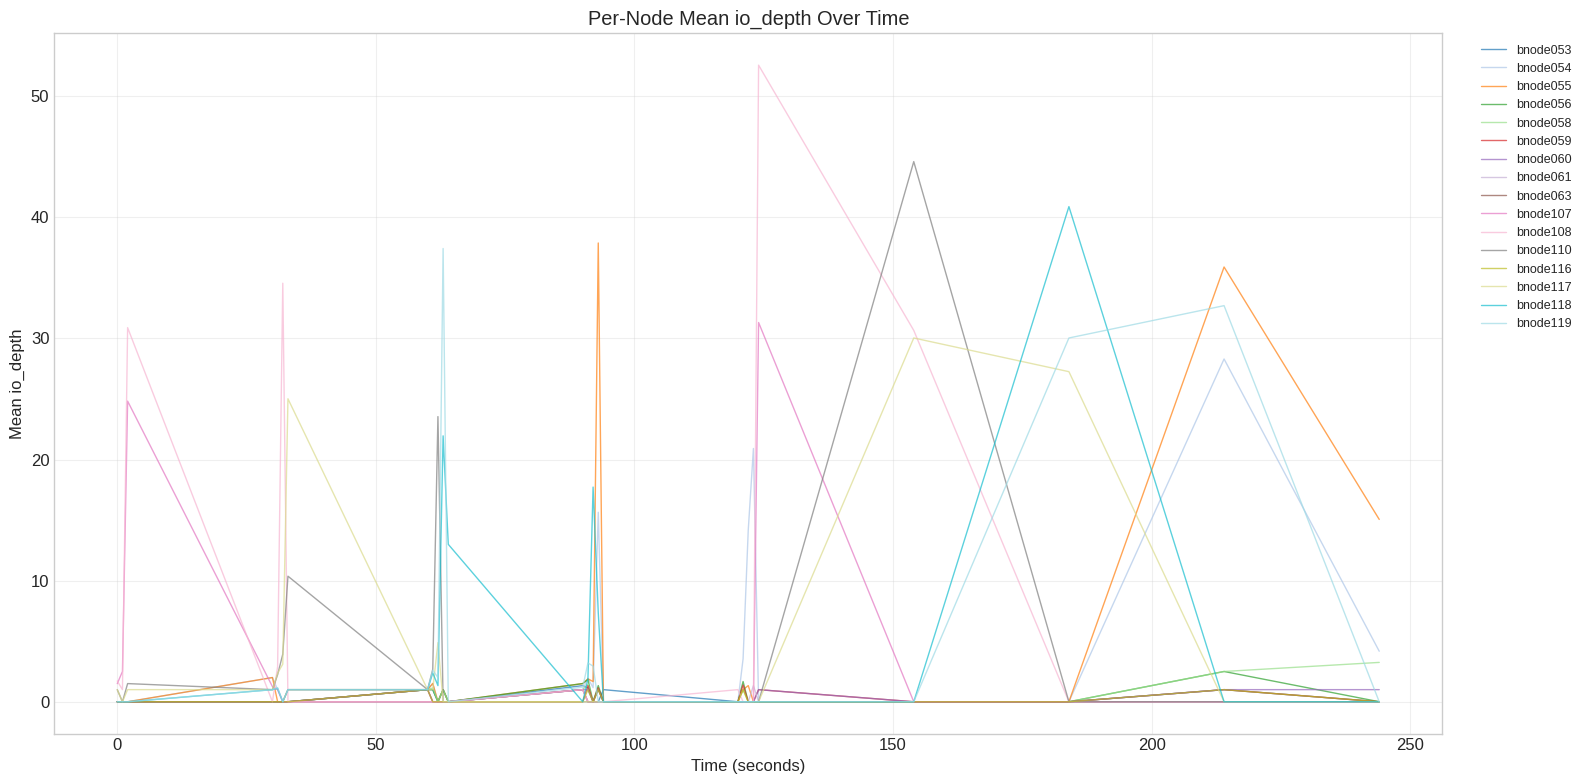

In [48]:
# Per-node io_depth over time
if df_iodepth is not None:
    node_time_stats = df_iodepth.groupby(['time_bucket', 'node']).agg({
        'io_depth': 'mean'
    }).reset_index()
    node_time_pivot = node_time_stats.pivot(index='time_bucket', columns='node', values='io_depth').fillna(0)

    fig, ax = plt.subplots(figsize=(16, 8))

    nodes = sorted(node_time_pivot.columns)
    colors = plt.cm.tab20(np.linspace(0, 1, len(nodes)))

    for i, node in enumerate(nodes):
        if node in node_time_pivot.columns:
            ax.plot(node_time_pivot.index, node_time_pivot[node], 
                    label=node, linewidth=1, alpha=0.7, color=colors[i])

    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Mean io_depth')
    ax.set_title('Per-Node Mean io_depth Over Time')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_depth_per_node_over_time.png', dpi=150, bbox_inches='tight')
    plt.show()

## 1.4 io_depth Heatmap

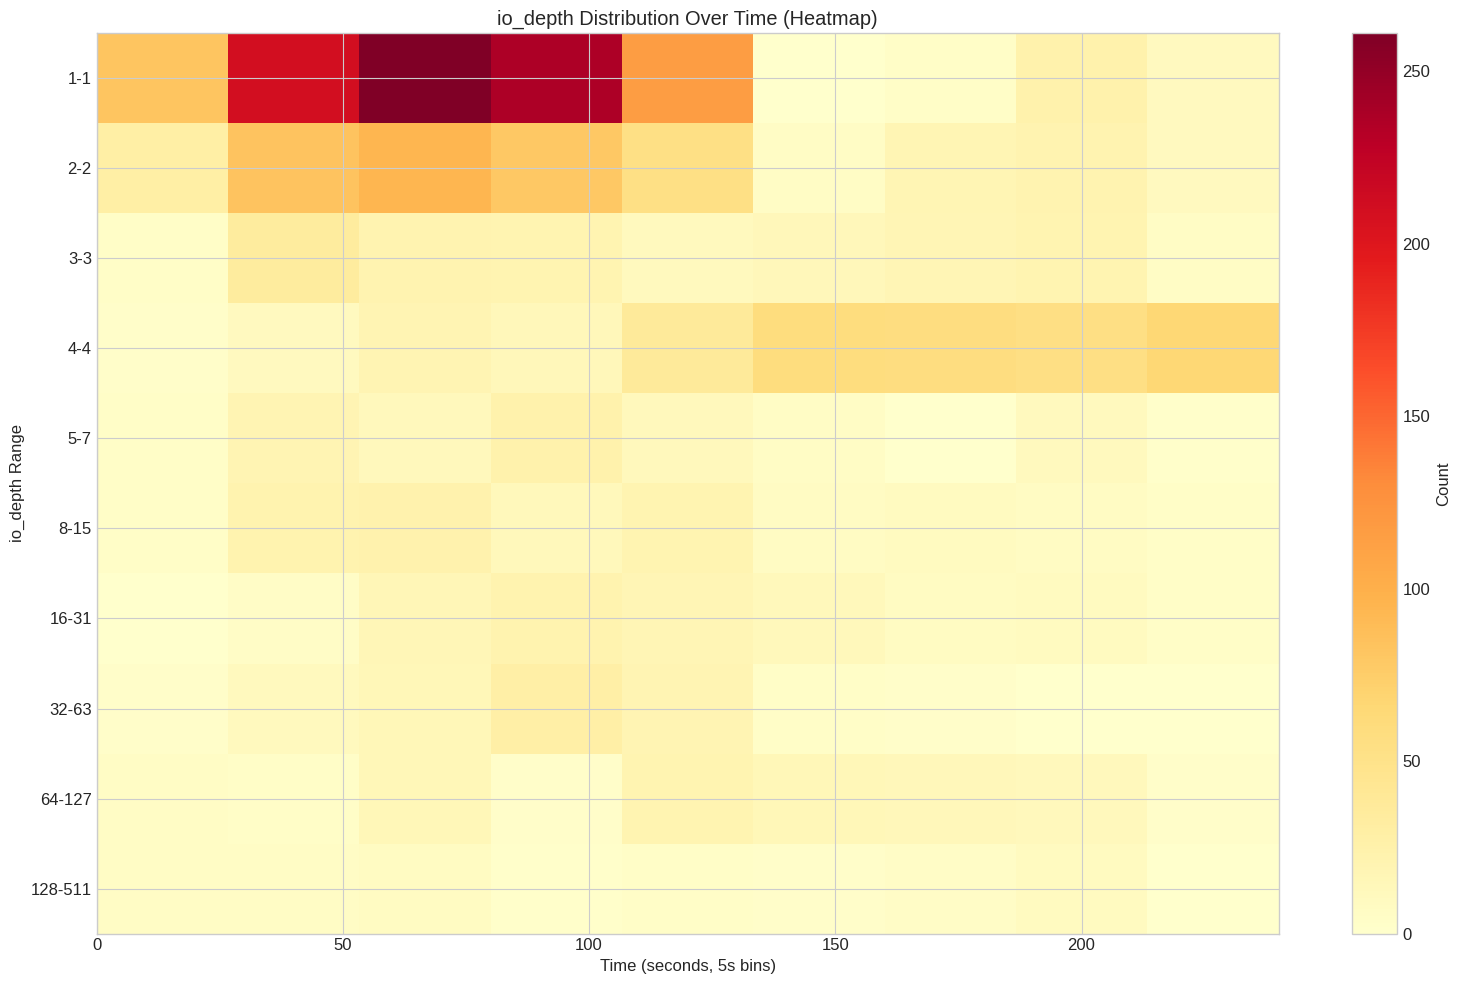

In [49]:
# Heatmap: io_depth distribution over time
if df_iodepth is not None:
    time_bin = 5  # seconds
    df_iodepth['time_bin'] = (df_iodepth['time_relative'] // time_bin).astype(int) * time_bin

    # Create histogram per time bin
    depth_bins = [1, 2, 3, 4, 5, 8, 16, 32, 64, 128, 512]
    heatmap_data = []

    for time_bin_val in sorted(df_iodepth['time_bin'].unique()):
        bin_df = df_iodepth[df_iodepth['time_bin'] == time_bin_val]
        row = {'time': time_bin_val}
        for i in range(len(depth_bins) - 1):
            lo, hi = depth_bins[i], depth_bins[i+1] - 1
            count = len(bin_df[(bin_df['io_depth'] >= lo) & (bin_df['io_depth'] <= hi)])
            row[f'{lo}-{hi}'] = count
        heatmap_data.append(row)

    heatmap_df = pd.DataFrame(heatmap_data).set_index('time')

    fig, ax = plt.subplots(figsize=(16, 10))

    im = ax.imshow(heatmap_df.T, aspect='auto', cmap='YlOrRd',
                   extent=[heatmap_df.index.min(), heatmap_df.index.max(), 
                           len(heatmap_df.columns)-0.5, -0.5])

    ax.set_xlabel(f'Time (seconds, {time_bin}s bins)')
    ax.set_ylabel('io_depth Range')
    ax.set_title('io_depth Distribution Over Time (Heatmap)')
    ax.set_yticks(range(len(heatmap_df.columns)))
    ax.set_yticklabels(heatmap_df.columns)

    cbar = plt.colorbar(im, ax=ax, label='Count')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_depth_heatmap.png', dpi=150)
    plt.show()

## 1.5 Batching Efficiency Analysis

In [50]:
# Batching efficiency analysis
if df_iodepth is not None:
    print("=" * 80)
    print("Batching Efficiency Analysis")
    print("=" * 80)

    total_submits = len(df_iodepth)
    total_sqes = df_iodepth['sqe_count'].sum()
    avg_batch_size = df_iodepth['io_depth'].mean()

    print(f"\nOverall Statistics:")
    print(f"  Total io_uring submits: {total_submits:,}")
    print(f"  Total SQEs submitted: {total_sqes:,}")
    print(f"  Average batch size (io_depth): {avg_batch_size:.2f}")

    # Efficiency metrics
    depth_1_count = len(df_iodepth[df_iodepth['io_depth'] == 1])
    depth_1_pct = depth_1_count / total_submits * 100
    depth_le4_count = len(df_iodepth[df_iodepth['io_depth'] <= 4])
    depth_le4_pct = depth_le4_count / total_submits * 100
    depth_gt16_count = len(df_iodepth[df_iodepth['io_depth'] > 16])
    depth_gt16_pct = depth_gt16_count / total_submits * 100

    print(f"\nBatching Efficiency:")
    print(f"  io_depth=1 (unbatched): {depth_1_count:,} ({depth_1_pct:.1f}%)")
    print(f"  io_depth<=4 (low batch): {depth_le4_count:,} ({depth_le4_pct:.1f}%)")
    print(f"  io_depth>16 (good batch): {depth_gt16_count:,} ({depth_gt16_pct:.1f}%)")

    # Theoretical efficiency
    ideal_batch_size = 64
    ideal_submits = total_sqes / ideal_batch_size
    efficiency = ideal_submits / total_submits * 100

    print(f"\nTheoretical Efficiency (assuming ideal batch_size={ideal_batch_size}):")
    print(f"  Actual submits: {total_submits:,}")
    print(f"  Ideal submits: {ideal_submits:,.0f}")
    print(f"  Efficiency: {efficiency:.1f}%")

    # Performance impact
    syscall_overhead_us = 0.5
    wasted_time_ms = (total_submits - ideal_submits) * syscall_overhead_us / 1000

    print(f"\nEstimated Performance Impact:")
    print(f"  Extra syscalls: {total_submits - ideal_submits:,.0f}")
    print(f"  Wasted time (at {syscall_overhead_us}us/syscall): {wasted_time_ms:.1f} ms")

    if depth_1_pct > 50:
        print("\n" + "*" * 80)
        print("*** CRITICAL: Batching is highly inefficient! ***")
        print("*** Most operations are submitted individually (io_depth=1) ***")
        print("*** This is likely caused by synchronous operations blocking io_uring ***")
        print("*" * 80)

Batching Efficiency Analysis

Overall Statistics:
  Total io_uring submits: 2,333
  Total SQEs submitted: 35,140
  Average batch size (io_depth): 15.06

Batching Efficiency:
  io_depth=1 (unbatched): 943 (40.4%)
  io_depth<=4 (low batch): 1,805 (77.4%)
  io_depth>16 (good batch): 283 (12.1%)

Theoretical Efficiency (assuming ideal batch_size=64):
  Actual submits: 2,333
  Ideal submits: 549
  Efficiency: 23.5%

Estimated Performance Impact:
  Extra syscalls: 1,784
  Wasted time (at 0.5us/syscall): 0.9 ms


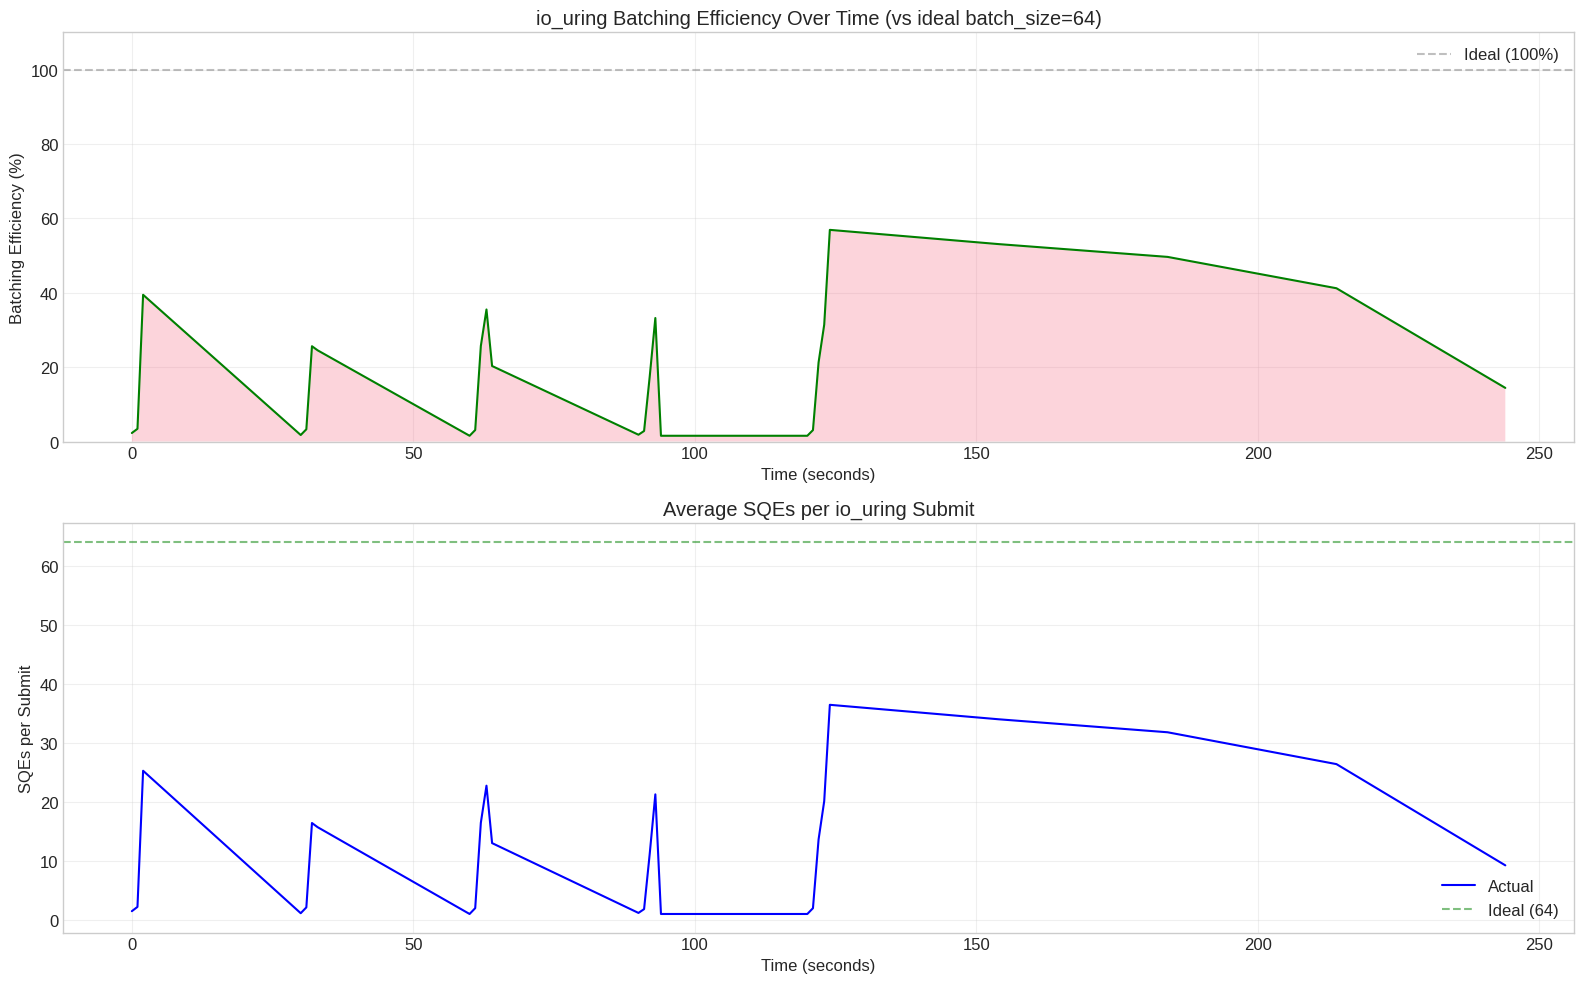

In [51]:
# Efficiency over time
if df_iodepth is not None:
    time_efficiency = df_iodepth.groupby('time_bucket').agg({
        'io_depth': 'mean',
        'sqe_count': ['sum', 'count']
    }).reset_index()
    time_efficiency.columns = ['time', 'mean_depth', 'total_sqes', 'submit_count']
    time_efficiency['efficiency'] = time_efficiency['mean_depth'] / 64 * 100
    time_efficiency['efficiency'] = time_efficiency['efficiency'].clip(upper=100)

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Efficiency over time
    ax = axes[0]
    ax.plot(time_efficiency['time'], time_efficiency['efficiency'], linewidth=1.5, color='green')
    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='Ideal (100%)')
    ax.fill_between(time_efficiency['time'], 0, time_efficiency['efficiency'], alpha=0.3)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Batching Efficiency (%)')
    ax.set_title('io_uring Batching Efficiency Over Time (vs ideal batch_size=64)')
    ax.set_ylim(0, 110)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # SQEs per submit
    ax = axes[1]
    ax.plot(time_efficiency['time'], time_efficiency['total_sqes'] / time_efficiency['submit_count'], 
            linewidth=1.5, color='blue', label='Actual')
    ax.axhline(y=64, color='green', linestyle='--', alpha=0.5, label='Ideal (64)')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('SQEs per Submit')
    ax.set_title('Average SQEs per io_uring Submit')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_depth_efficiency.png', dpi=150)
    plt.show()

## 1.6 io_depth Summary

In [52]:
# Final summary
if df_iodepth is not None:
    print("=" * 80)
    print("io_depth Analysis Summary")
    print("=" * 80)

    print(f"\nSource: {RESULTS_DIR}")
    print(f"Total submit events: {len(df_iodepth):,}")
    print(f"Total SQEs: {df_iodepth['sqe_count'].sum():,}")
    print(f"Duration: {df_iodepth['time_relative'].max():.1f} seconds")

    print(f"\nio_depth Statistics:")
    print(f"  Mean: {df_iodepth['io_depth'].mean():.2f}")
    print(f"  Median: {df_iodepth['io_depth'].median():.2f}")
    print(f"  Min: {df_iodepth['io_depth'].min()}")
    print(f"  Max: {df_iodepth['io_depth'].max()}")
    print(f"  Std: {df_iodepth['io_depth'].std():.2f}")

    print(f"\nPercentiles:")
    for p in [25, 50, 75, 90, 95, 99]:
        val = df_iodepth['io_depth'].quantile(p/100)
        print(f"  P{p}: {val:.1f}")

    print(f"\nBatching Breakdown:")
    for label, (lo, hi) in [('unbatched (=1)', (1, 1)), 
                             ('low (2-4)', (2, 4)), 
                             ('medium (5-16)', (5, 16)),
                             ('good (17-64)', (17, 64)),
                             ('excellent (>64)', (65, 9999))]:
        count = len(df_iodepth[(df_iodepth['io_depth'] >= lo) & (df_iodepth['io_depth'] <= hi)])
        pct = count / len(df_iodepth) * 100
        print(f"  {label}: {count:,} ({pct:.1f}%)")

    print(f"\n" + "=" * 80)
    if df_iodepth['io_depth'].mean() < 4:
        print("DIAGNOSIS: io_uring batching is severely inefficient.")
        print("CAUSE: Likely synchronous operations (file open, fsync) blocking the reactor.")
        print("SOLUTION: Ensure all file operations use async io_uring operations.")
    elif df_iodepth['io_depth'].mean() < 16:
        print("DIAGNOSIS: io_uring batching is suboptimal.")
        print("Consider tuning submit_depth threshold or wait_submit_timeout.")
    else:
        print("DIAGNOSIS: io_uring batching appears efficient.")
    print("=" * 80)

io_depth Analysis Summary

Source: /work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.01.24-22.49.26-debug_large/2026.01.24-22.56.47-541890.nqsv-16
Total submit events: 2,333
Total SQEs: 35,140
Duration: 244.7 seconds

io_depth Statistics:
  Mean: 15.06
  Median: 2.00
  Min: 1
  Max: 553
  Std: 51.10

Percentiles:
  P25: 1.0
  P50: 2.0
  P75: 4.0
  P90: 30.8
  P95: 100.0
  P99: 183.8

Batching Breakdown:
  unbatched (=1): 943 (40.4%)
  low (2-4): 862 (36.9%)
  medium (5-16): 245 (10.5%)
  good (17-64): 135 (5.8%)
  excellent (>64): 148 (6.3%)

DIAGNOSIS: io_uring batching is suboptimal.
Consider tuning submit_depth threshold or wait_submit_timeout.


---
# Part 2: I/O Timing Analysis

Analyzes actual disk I/O latency and bandwidth (read_fixed_direct / write_fixed_direct).

## Key Metrics
- **elapsed_us**: Actual disk I/O latency in microseconds
- **bandwidth_mib_s**: Per-operation bandwidth in MiB/s
- **op**: Operation type (READ or WRITE)

In [53]:
# Load I/O timing data
df_timing = load_csv_if_exists(RESULTS_DIR / 'io_timing_raw.csv', 'io_timing_raw.csv')

if df_timing is not None:
    df_timing['datetime'] = df_timing['timestamp'].apply(parse_timestamp)
    df_timing = df_timing.dropna(subset=['datetime'])
    
    start_time = df_timing['datetime'].min()
    df_timing['time_relative'] = (df_timing['datetime'] - start_time).dt.total_seconds()
    df_timing['elapsed_ms'] = df_timing['elapsed_us'] / 1000
    df_timing['node'] = df_timing['node'].apply(clean_node_name)
    df_timing['time_bucket'] = (df_timing['time_relative'] // 1).astype(int)
    
    print(f"\nTime range: {df_timing['datetime'].min()} - {df_timing['datetime'].max()}")
    print(f"Duration: {df_timing['time_relative'].max():.1f} seconds")
    print(f"Operations: {df_timing['op'].unique()}")
    print(f"Nodes: {sorted(df_timing['node'].unique())}")
    print(f"\nCounts by operation:")
    print(df_timing['op'].value_counts())

Loaded io_timing_raw.csv: 17,570 records

Time range: 2026-01-24 13:59:28.543343+00:00 - 2026-01-24 14:03:33.293522+00:00
Duration: 244.8 seconds
Operations: ['WRITE' 'READ']
Nodes: ['bnode053', 'bnode054', 'bnode055', 'bnode056', 'bnode058', 'bnode059', 'bnode060', 'bnode061', 'bnode063', 'bnode107', 'bnode108', 'bnode110', 'bnode116', 'bnode117', 'bnode118', 'bnode119']

Counts by operation:
op
WRITE    8946
READ     8624
Name: count, dtype: int64


## 2.1 Overall Bandwidth Distribution

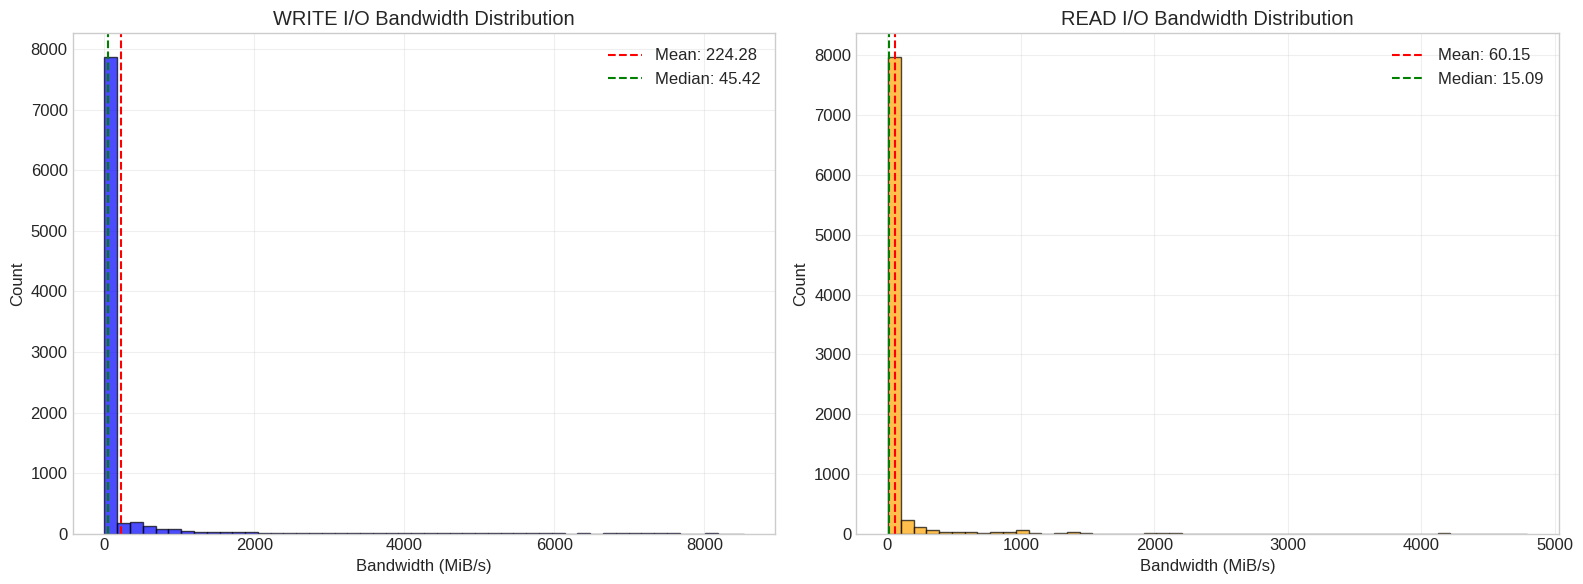


WRITE: count=8,946, mean_bw=224.28 MiB/s
READ:  count=8,624, mean_bw=60.15 MiB/s


In [54]:
# Bandwidth distribution
if df_timing is not None:
    df_timing_write = df_timing[df_timing['op'] == 'WRITE']
    df_timing_read = df_timing[df_timing['op'] == 'READ']

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    ax = axes[0]
    if len(df_timing_write) > 0:
        ax.hist(df_timing_write['bandwidth_mib_s'], bins=50, alpha=0.7, color='blue', edgecolor='black')
        ax.axvline(df_timing_write['bandwidth_mib_s'].mean(), color='red', linestyle='--', label=f"Mean: {df_timing_write['bandwidth_mib_s'].mean():.2f}")
        ax.axvline(df_timing_write['bandwidth_mib_s'].median(), color='green', linestyle='--', label=f"Median: {df_timing_write['bandwidth_mib_s'].median():.2f}")
    ax.set_xlabel('Bandwidth (MiB/s)')
    ax.set_ylabel('Count')
    ax.set_title('WRITE I/O Bandwidth Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    if len(df_timing_read) > 0:
        ax.hist(df_timing_read['bandwidth_mib_s'], bins=50, alpha=0.7, color='orange', edgecolor='black')
        ax.axvline(df_timing_read['bandwidth_mib_s'].mean(), color='red', linestyle='--', label=f"Mean: {df_timing_read['bandwidth_mib_s'].mean():.2f}")
        ax.axvline(df_timing_read['bandwidth_mib_s'].median(), color='green', linestyle='--', label=f"Median: {df_timing_read['bandwidth_mib_s'].median():.2f}")
    ax.set_xlabel('Bandwidth (MiB/s)')
    ax.set_ylabel('Count')
    ax.set_title('READ I/O Bandwidth Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_timing_bandwidth_distribution.png', dpi=150)
    plt.show()

    print(f"\nWRITE: count={len(df_timing_write):,}, mean_bw={df_timing_write['bandwidth_mib_s'].mean():.2f} MiB/s")
    print(f"READ:  count={len(df_timing_read):,}, mean_bw={df_timing_read['bandwidth_mib_s'].mean():.2f} MiB/s")

## 2.2 Bandwidth Over Time (All Nodes Combined)

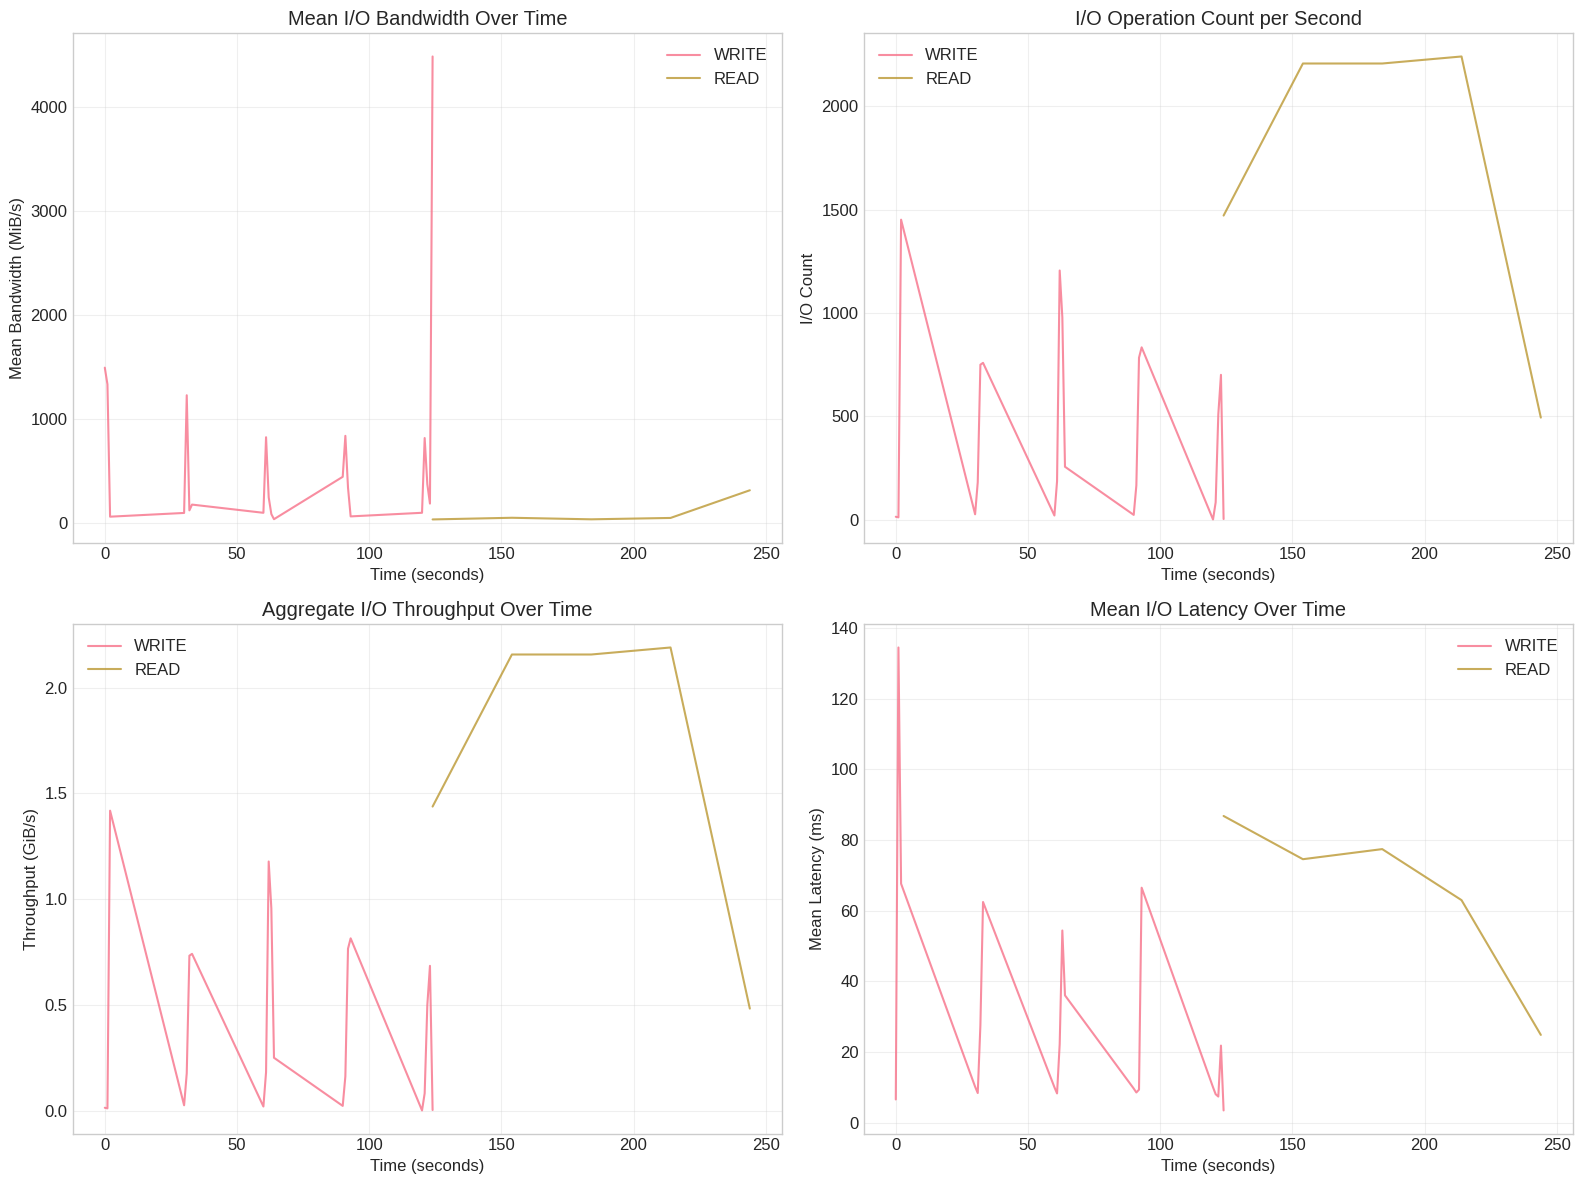

In [55]:
# Bandwidth and latency over time
if df_timing is not None:
    time_stats = df_timing.groupby(['time_bucket', 'op']).agg({
        'bandwidth_mib_s': ['mean', 'median', 'min', 'max', 'count'],
        'elapsed_ms': ['mean', 'median'],
        'bytes': 'sum'
    }).reset_index()
    time_stats.columns = ['time', 'op', 'bw_mean', 'bw_median', 'bw_min', 'bw_max', 'io_count', 'latency_mean', 'latency_median', 'total_bytes']
    time_stats['throughput_gib_s'] = time_stats['total_bytes'] / (1024**3)

    write_stats = time_stats[time_stats['op'] == 'WRITE']
    read_stats = time_stats[time_stats['op'] == 'READ']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    ax = axes[0, 0]
    if len(write_stats) > 0:
        ax.plot(write_stats['time'], write_stats['bw_mean'], label='WRITE', linewidth=1.5, alpha=0.8)
    if len(read_stats) > 0:
        ax.plot(read_stats['time'], read_stats['bw_mean'], label='READ', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Mean Bandwidth (MiB/s)')
    ax.set_title('Mean I/O Bandwidth Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[0, 1]
    if len(write_stats) > 0:
        ax.plot(write_stats['time'], write_stats['io_count'], label='WRITE', linewidth=1.5, alpha=0.8)
    if len(read_stats) > 0:
        ax.plot(read_stats['time'], read_stats['io_count'], label='READ', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('I/O Count')
    ax.set_title('I/O Operation Count per Second')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1, 0]
    if len(write_stats) > 0:
        ax.plot(write_stats['time'], write_stats['throughput_gib_s'], label='WRITE', linewidth=1.5, alpha=0.8)
    if len(read_stats) > 0:
        ax.plot(read_stats['time'], read_stats['throughput_gib_s'], label='READ', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title('Aggregate I/O Throughput Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    if len(write_stats) > 0:
        ax.plot(write_stats['time'], write_stats['latency_mean'], label='WRITE', linewidth=1.5, alpha=0.8)
    if len(read_stats) > 0:
        ax.plot(read_stats['time'], read_stats['latency_mean'], label='READ', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Mean Latency (ms)')
    ax.set_title('Mean I/O Latency Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_timing_over_time.png', dpi=150)
    plt.show()

## 2.3 Per-Node Bandwidth Over Time

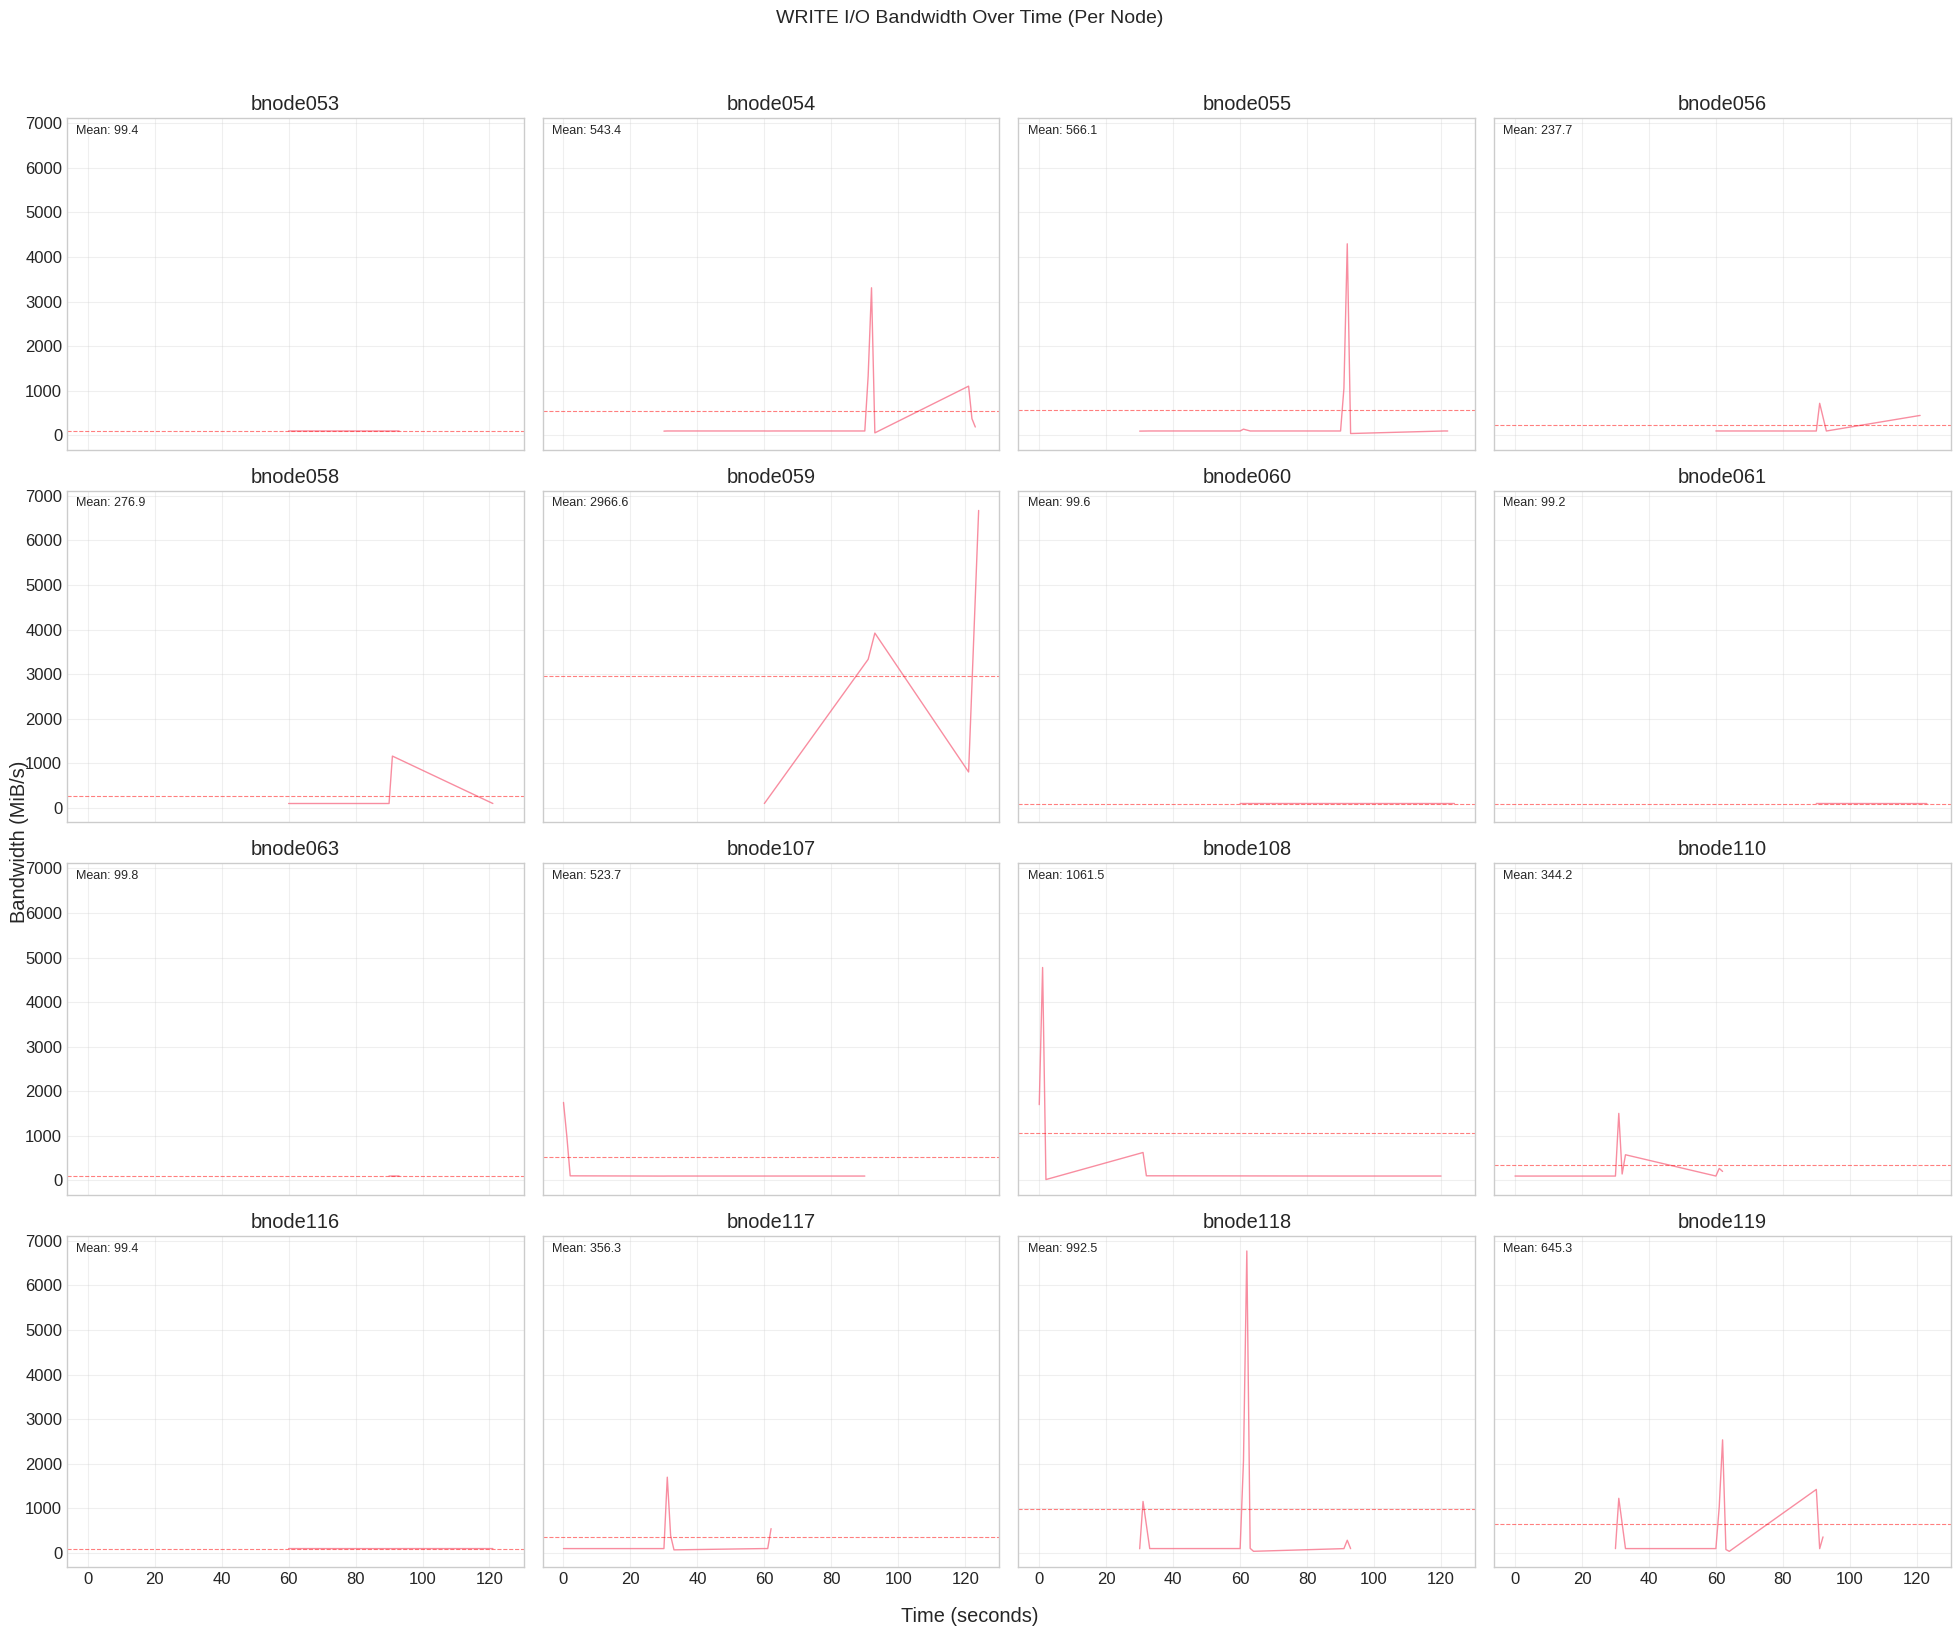

In [56]:
# Per-node bandwidth over time helper function
def plot_per_node_bandwidth(data, op_name, filename):
    if len(data) == 0:
        print(f"No {op_name} data")
        return
    
    # Aggregate by time bucket and node
    node_time_stats = data.groupby(['time_bucket', 'node']).agg({
        'bandwidth_mib_s': 'mean',
        'bytes': 'sum'
    }).reset_index()
    node_time_stats['throughput_gib_s'] = node_time_stats['bytes'] / (1024**3)
    
    nodes = sorted(data['node'].unique())
    n_nodes = len(nodes)
    
    # Calculate grid size
    n_cols = 4
    n_rows = (n_nodes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, node in enumerate(nodes):
        ax = axes[i]
        node_data = node_time_stats[node_time_stats['node'] == node]
        
        ax.plot(node_data['time_bucket'], node_data['bandwidth_mib_s'], linewidth=1, alpha=0.8)
        ax.set_title(f'{node}')
        ax.grid(True, alpha=0.3)
        
        # Add mean line
        mean_bw = node_data['bandwidth_mib_s'].mean()
        ax.axhline(y=mean_bw, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        ax.text(0.02, 0.98, f'Mean: {mean_bw:.1f}', transform=ax.transAxes, fontsize=9, va='top')
    
    # Hide unused subplots
    for i in range(n_nodes, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'{op_name} I/O Bandwidth Over Time (Per Node)', fontsize=14, y=1.02)
    fig.supxlabel('Time (seconds)')
    fig.supylabel('Bandwidth (MiB/s)')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_timing is not None:
    df_timing_write = df_timing[df_timing['op'] == 'WRITE']
    df_timing_read = df_timing[df_timing['op'] == 'READ']
    plot_per_node_bandwidth(df_timing_write, 'WRITE', 'io_timing_write_per_node.png')

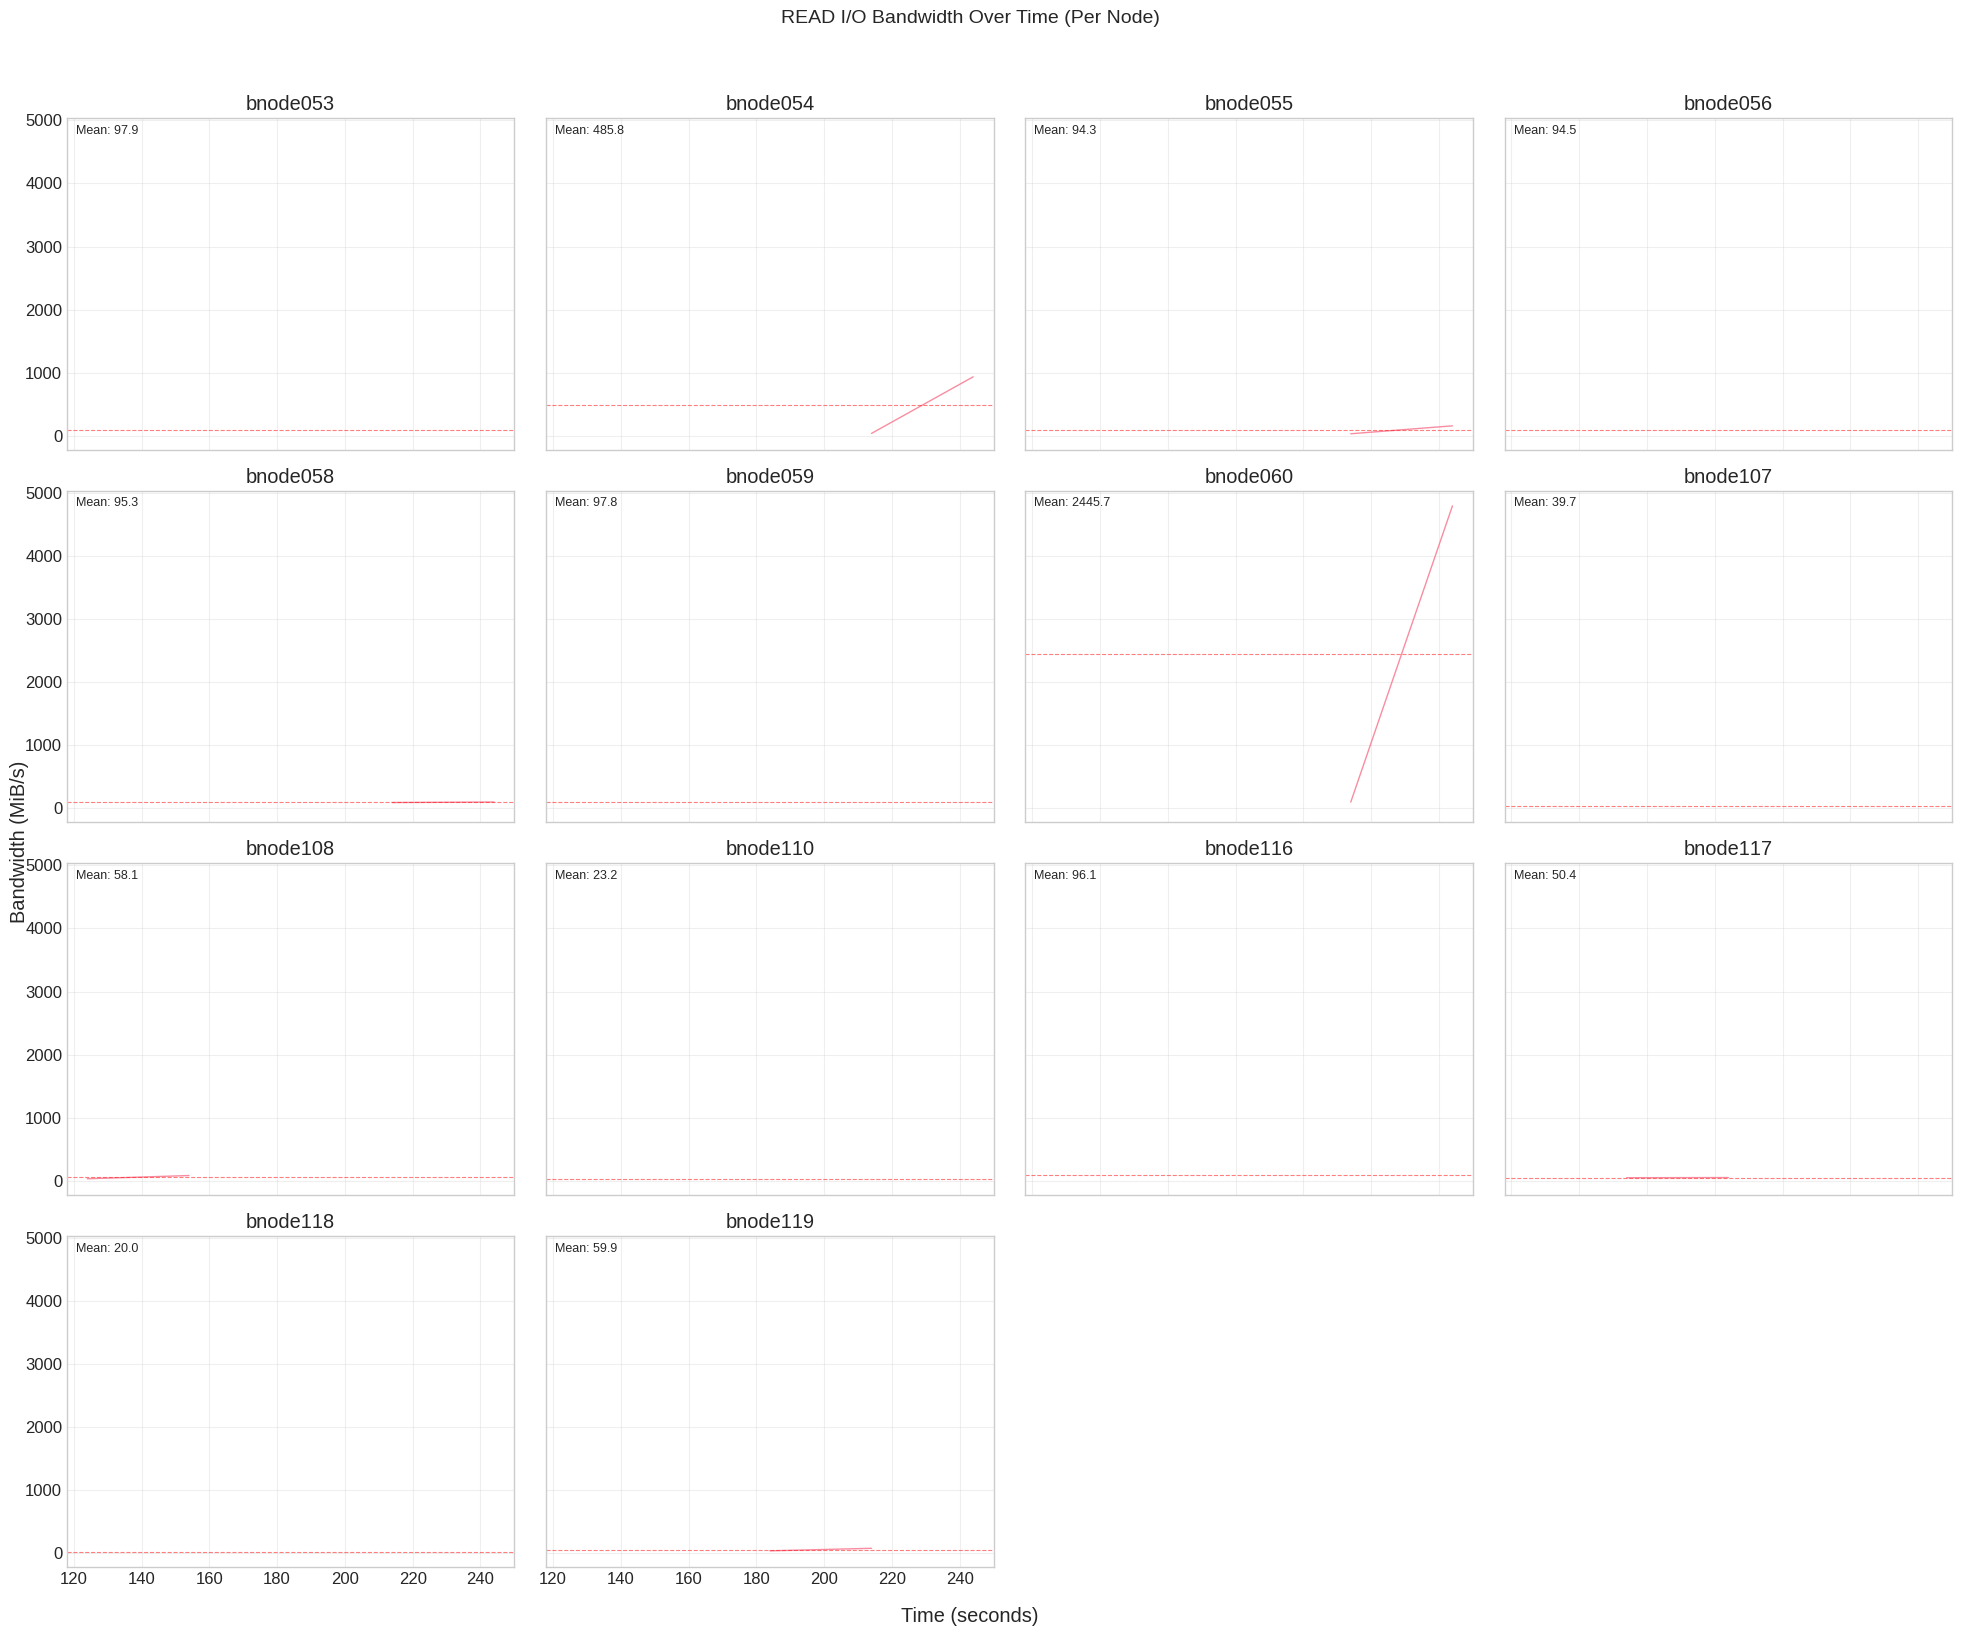

In [57]:
# READ per-node bandwidth
if df_timing is not None:
    df_timing_read = df_timing[df_timing['op'] == 'READ']
    plot_per_node_bandwidth(df_timing_read, 'READ', 'io_timing_read_per_node.png')

## 2.4 Per-Node Throughput Over Time

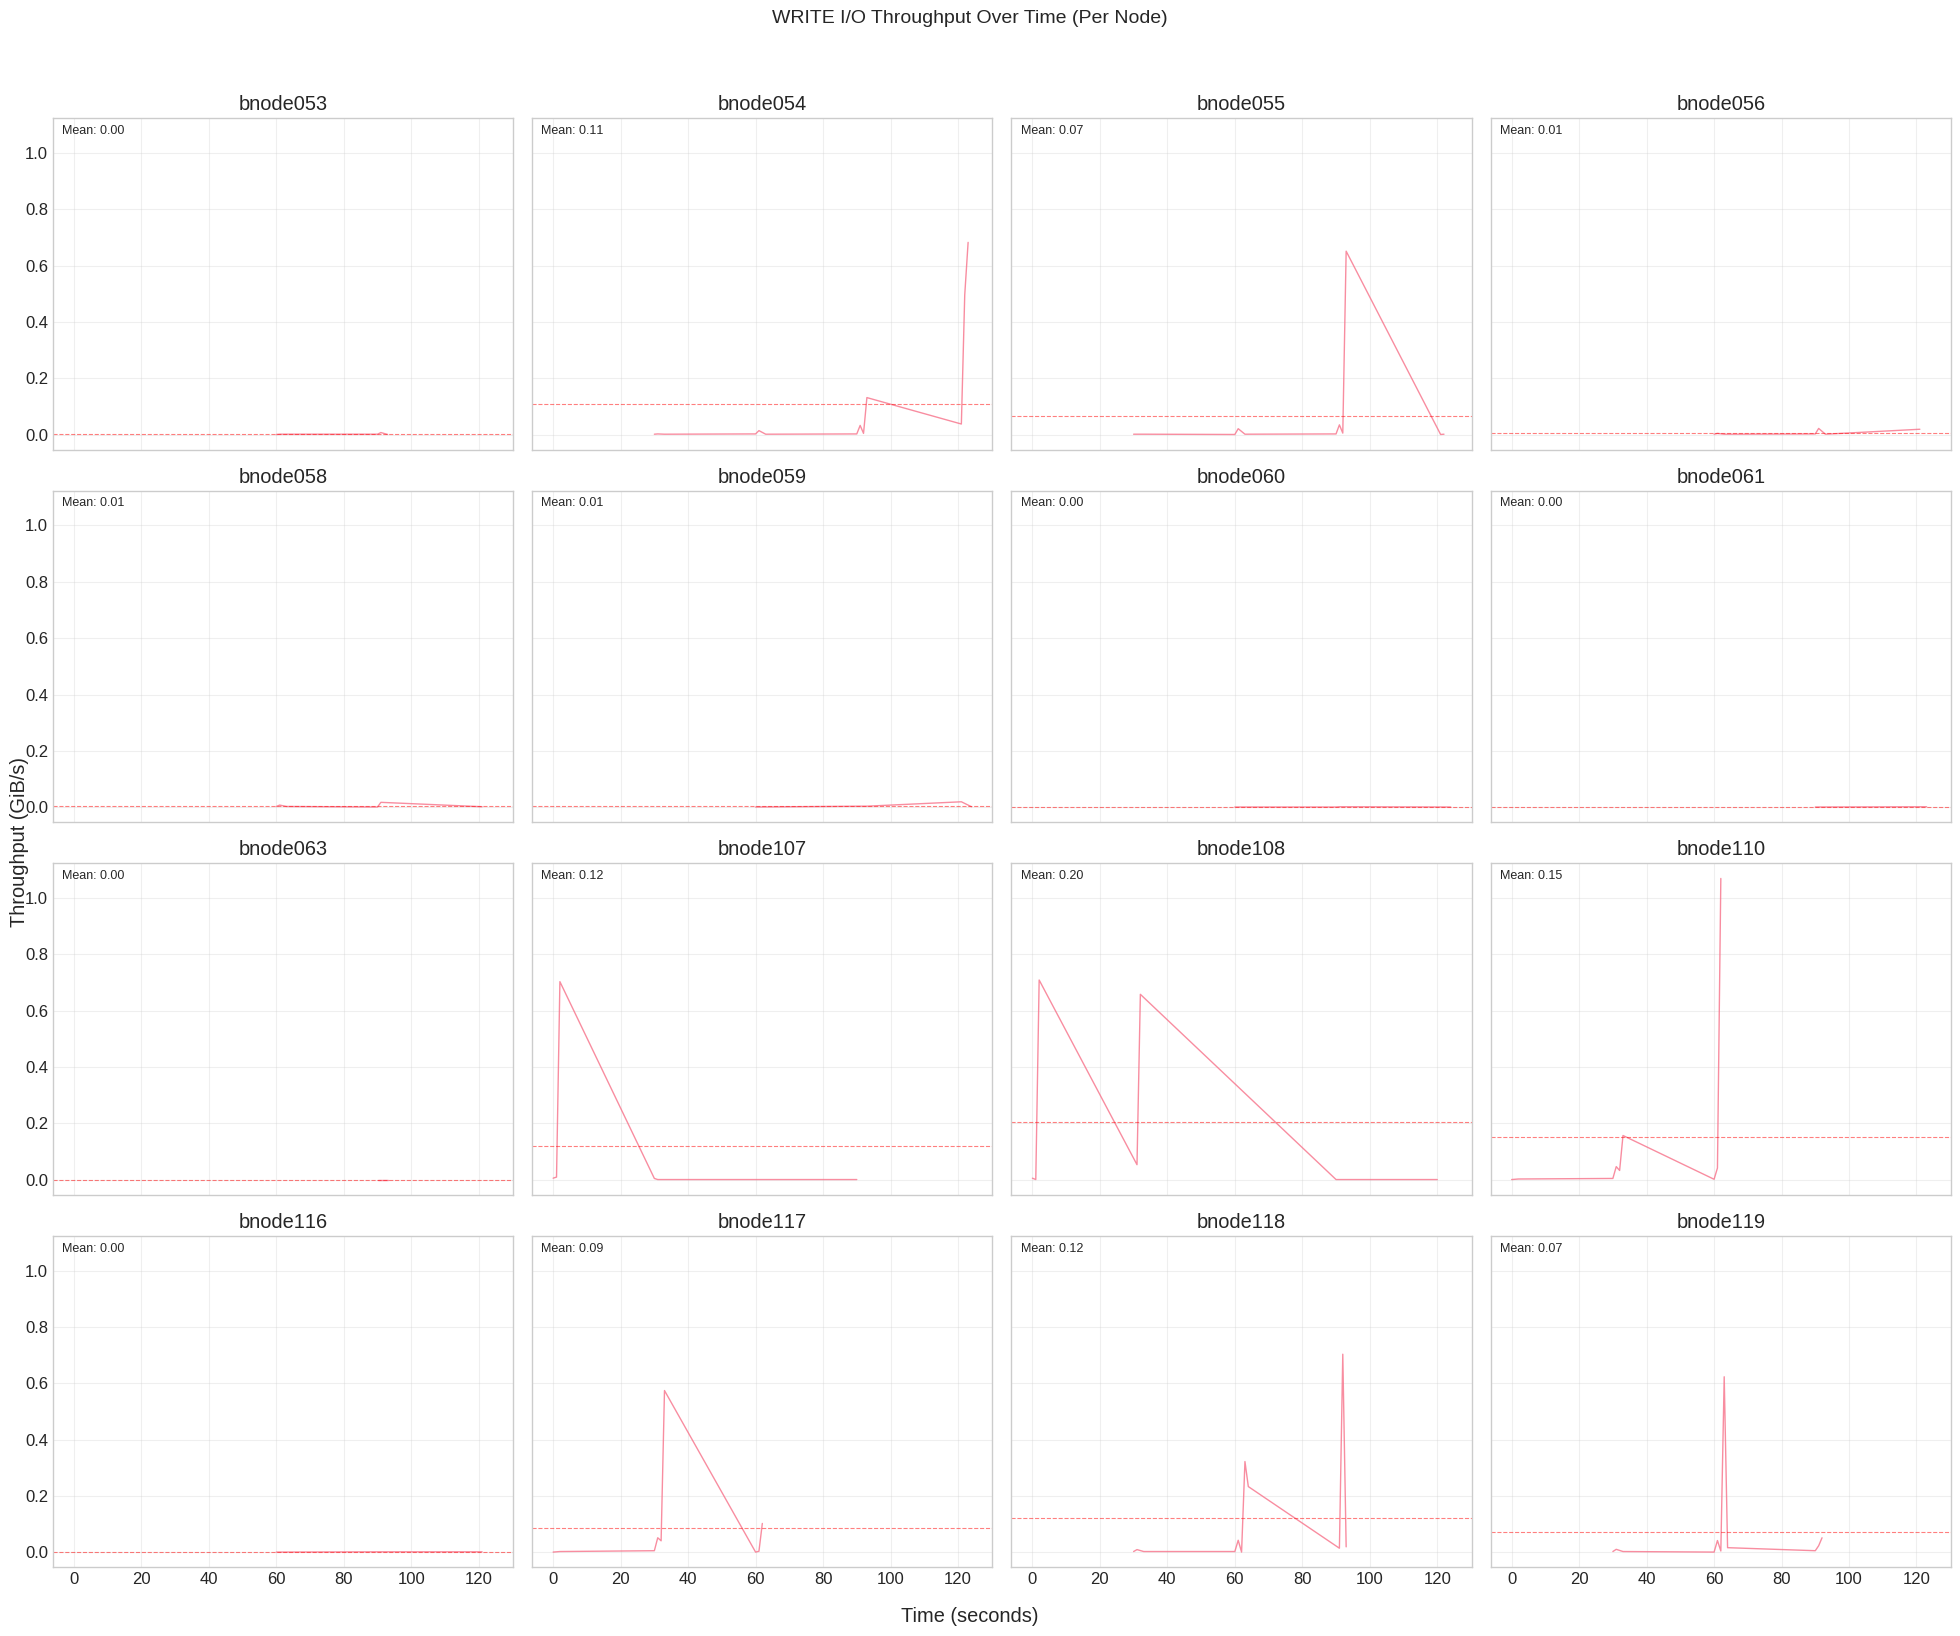

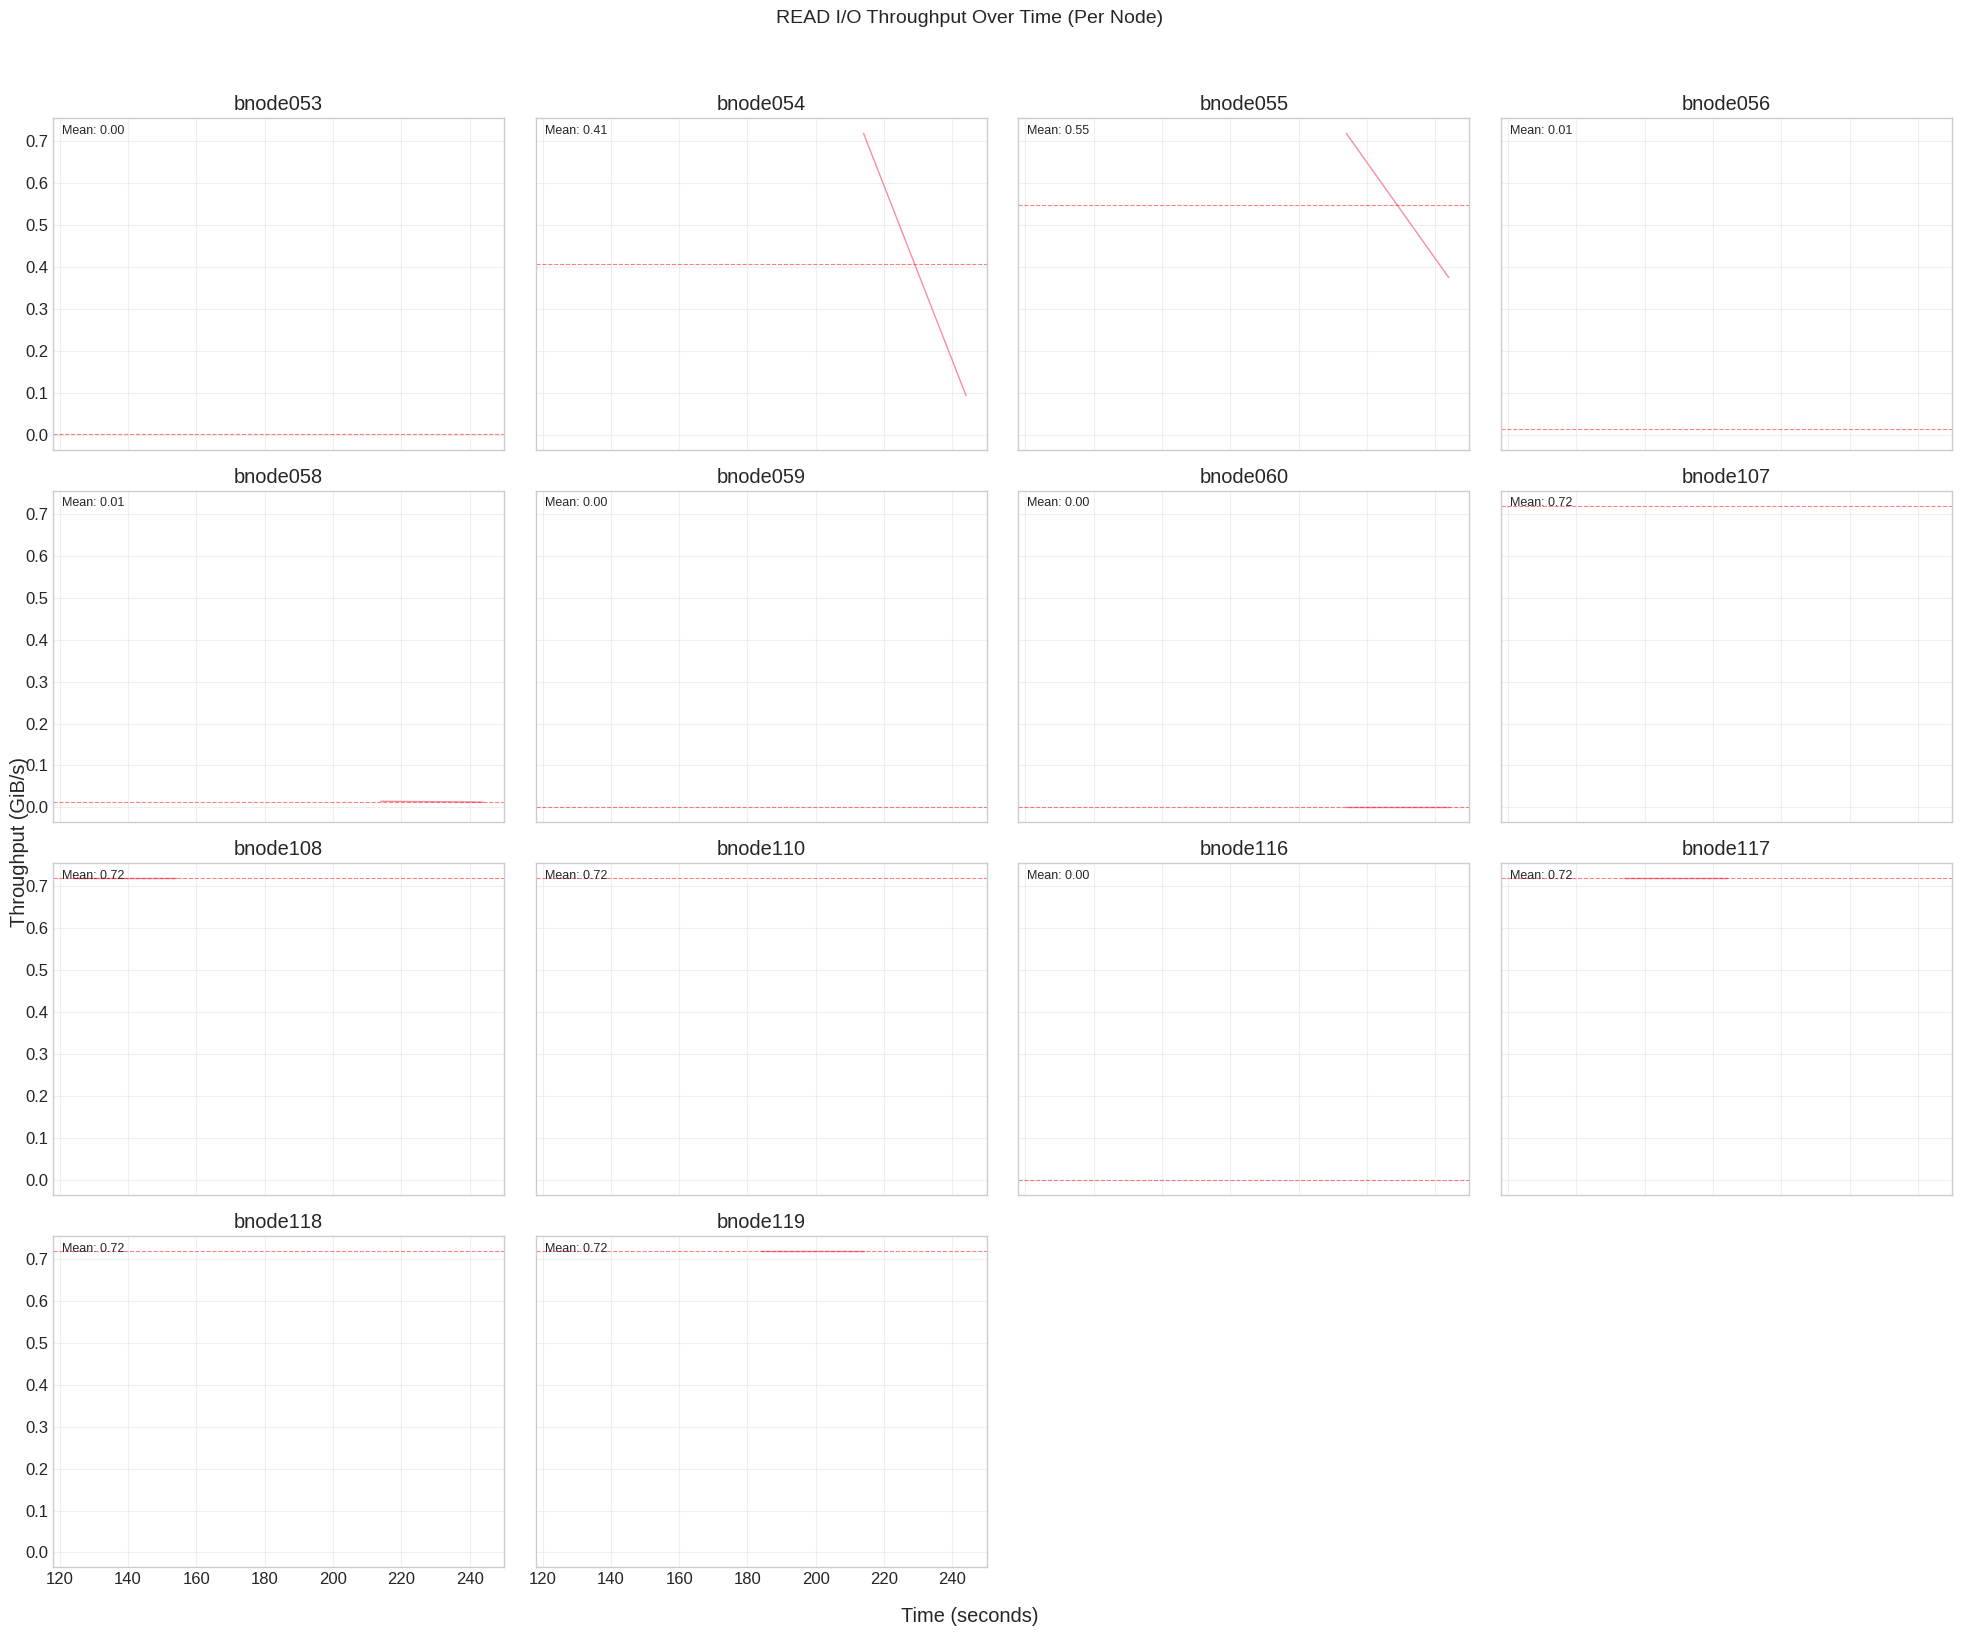

In [58]:
def plot_per_node_throughput(data, op_name, filename):
    if len(data) == 0:
        print(f"No {op_name} data")
        return
    
    # Aggregate by time bucket and node
    node_time_stats = data.groupby(['time_bucket', 'node']).agg({
        'bytes': 'sum',
        'bandwidth_mib_s': 'count'
    }).reset_index()
    node_time_stats.columns = ['time_bucket', 'node', 'total_bytes', 'io_count']
    node_time_stats['throughput_gib_s'] = node_time_stats['total_bytes'] / (1024**3)
    
    nodes = sorted(data['node'].unique())
    n_nodes = len(nodes)
    
    n_cols = 4
    n_rows = (n_nodes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, node in enumerate(nodes):
        ax = axes[i]
        node_data = node_time_stats[node_time_stats['node'] == node]
        
        ax.plot(node_data['time_bucket'], node_data['throughput_gib_s'], linewidth=1, alpha=0.8)
        ax.set_title(f'{node}')
        ax.grid(True, alpha=0.3)
        
        mean_tp = node_data['throughput_gib_s'].mean()
        ax.axhline(y=mean_tp, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        ax.text(0.02, 0.98, f'Mean: {mean_tp:.2f}', transform=ax.transAxes, fontsize=9, va='top')
    
    for i in range(n_nodes, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'{op_name} I/O Throughput Over Time (Per Node)', fontsize=14, y=1.02)
    fig.supxlabel('Time (seconds)')
    fig.supylabel('Throughput (GiB/s)')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_timing is not None:
    df_timing_write = df_timing[df_timing['op'] == 'WRITE']
    df_timing_read = df_timing[df_timing['op'] == 'READ']
    plot_per_node_throughput(df_timing_write, 'WRITE', 'io_timing_write_throughput_per_node.png')
    plot_per_node_throughput(df_timing_read, 'READ', 'io_timing_read_throughput_per_node.png')

## 2.5 Per-Node I/O Count Over Time

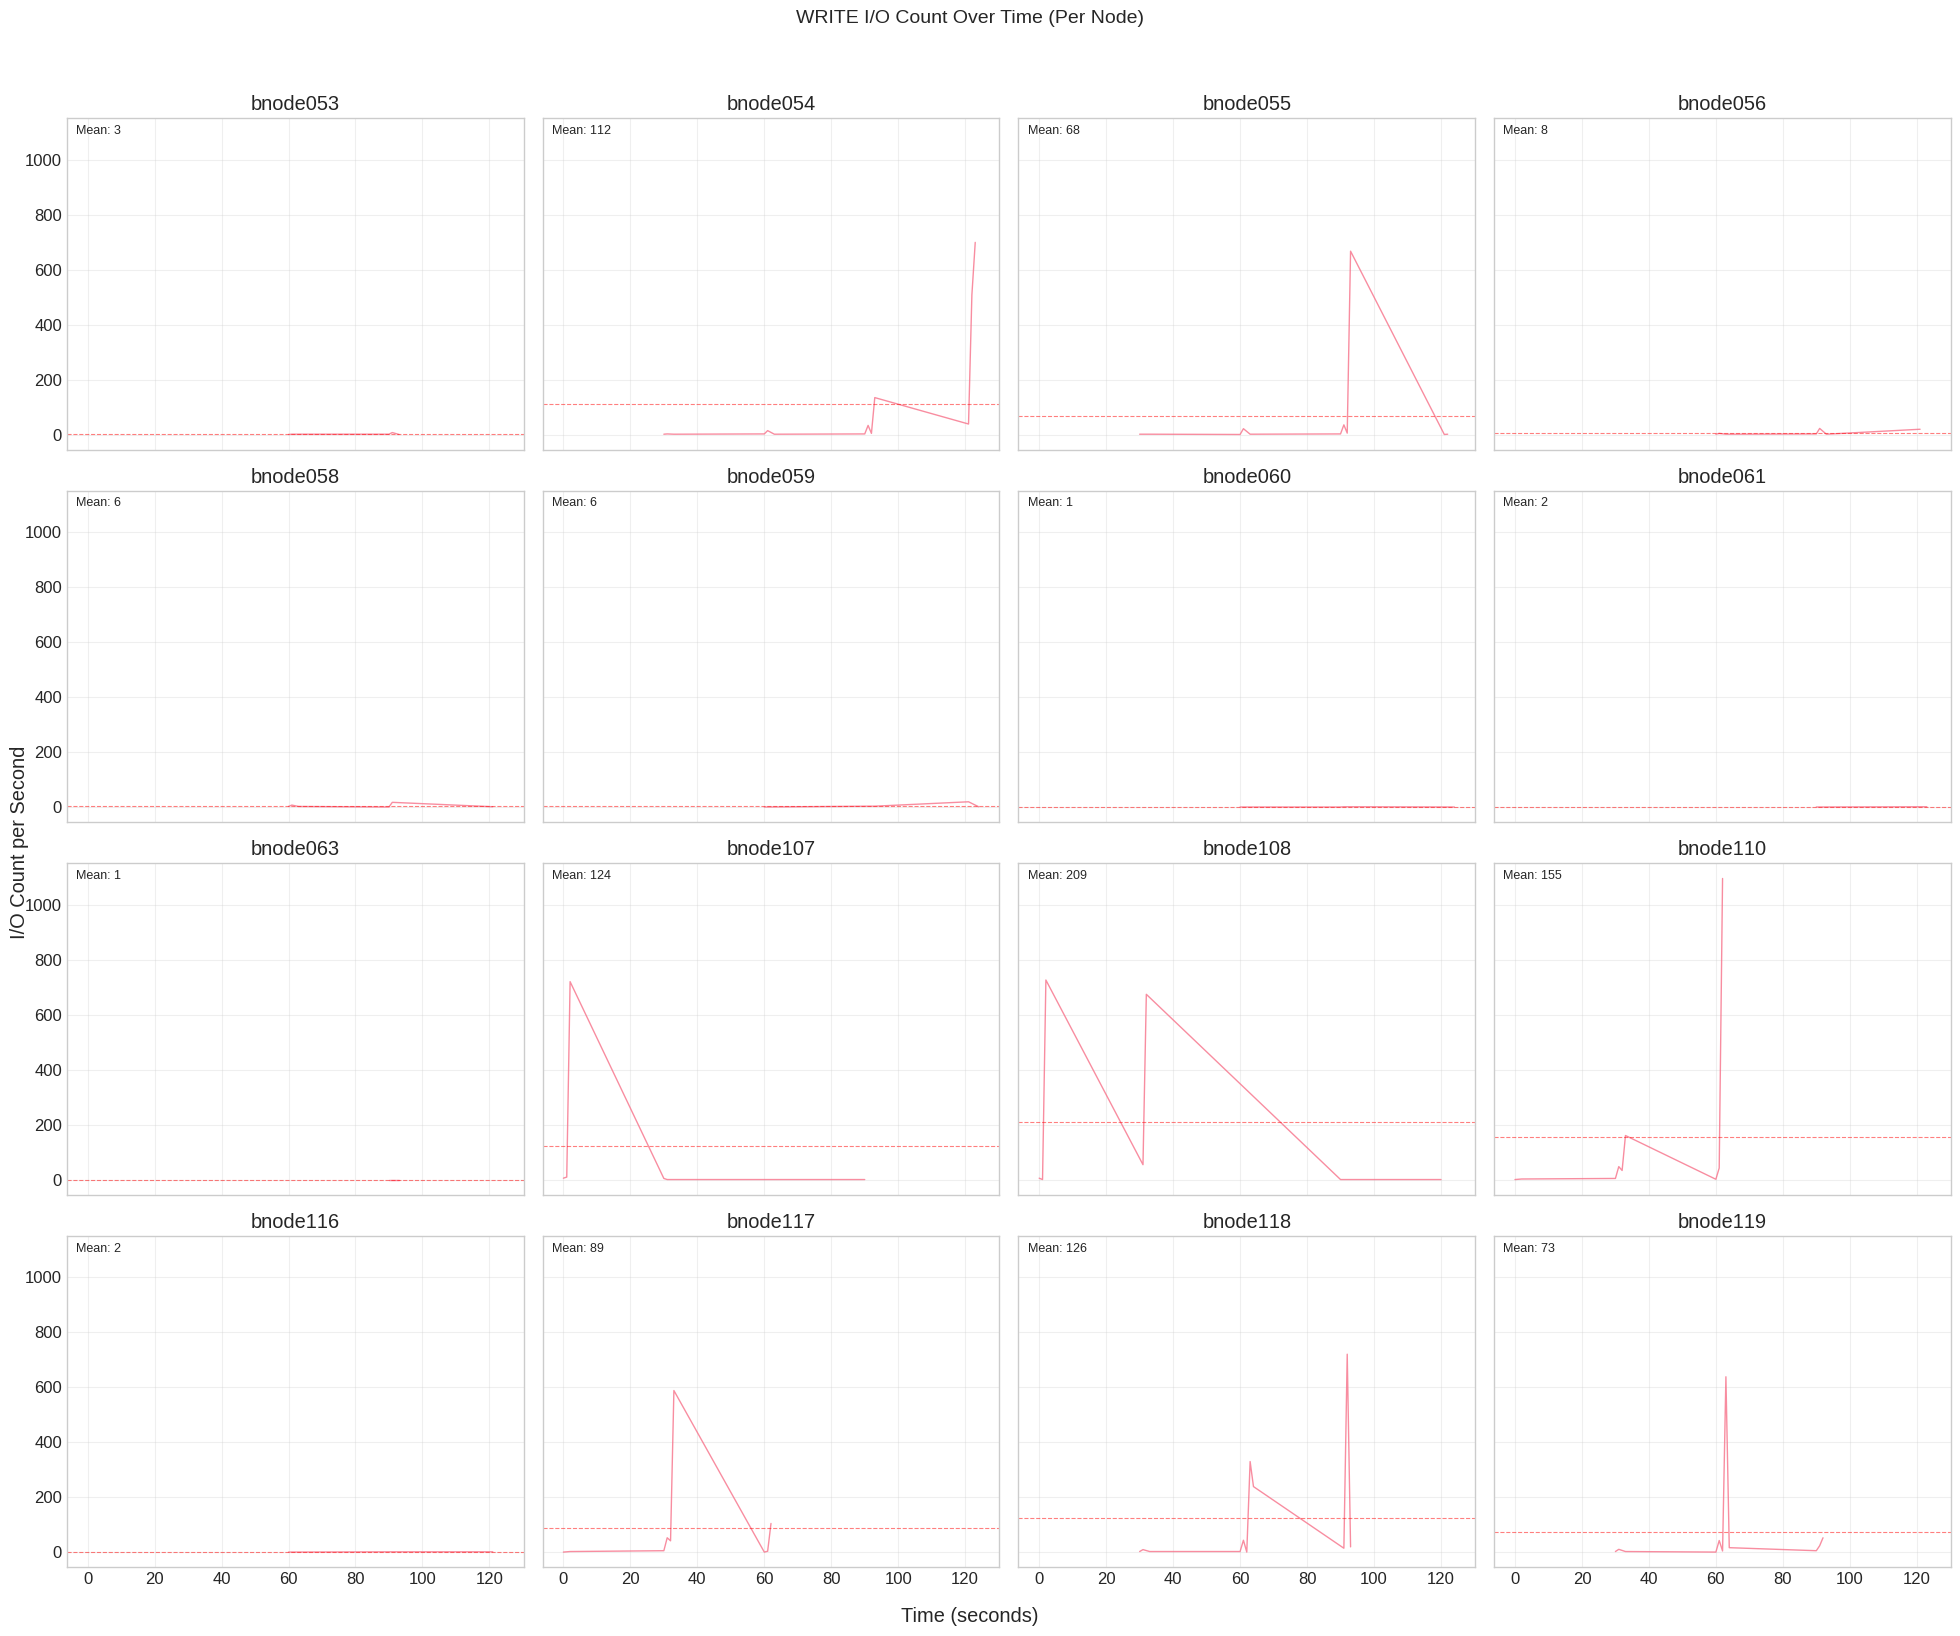

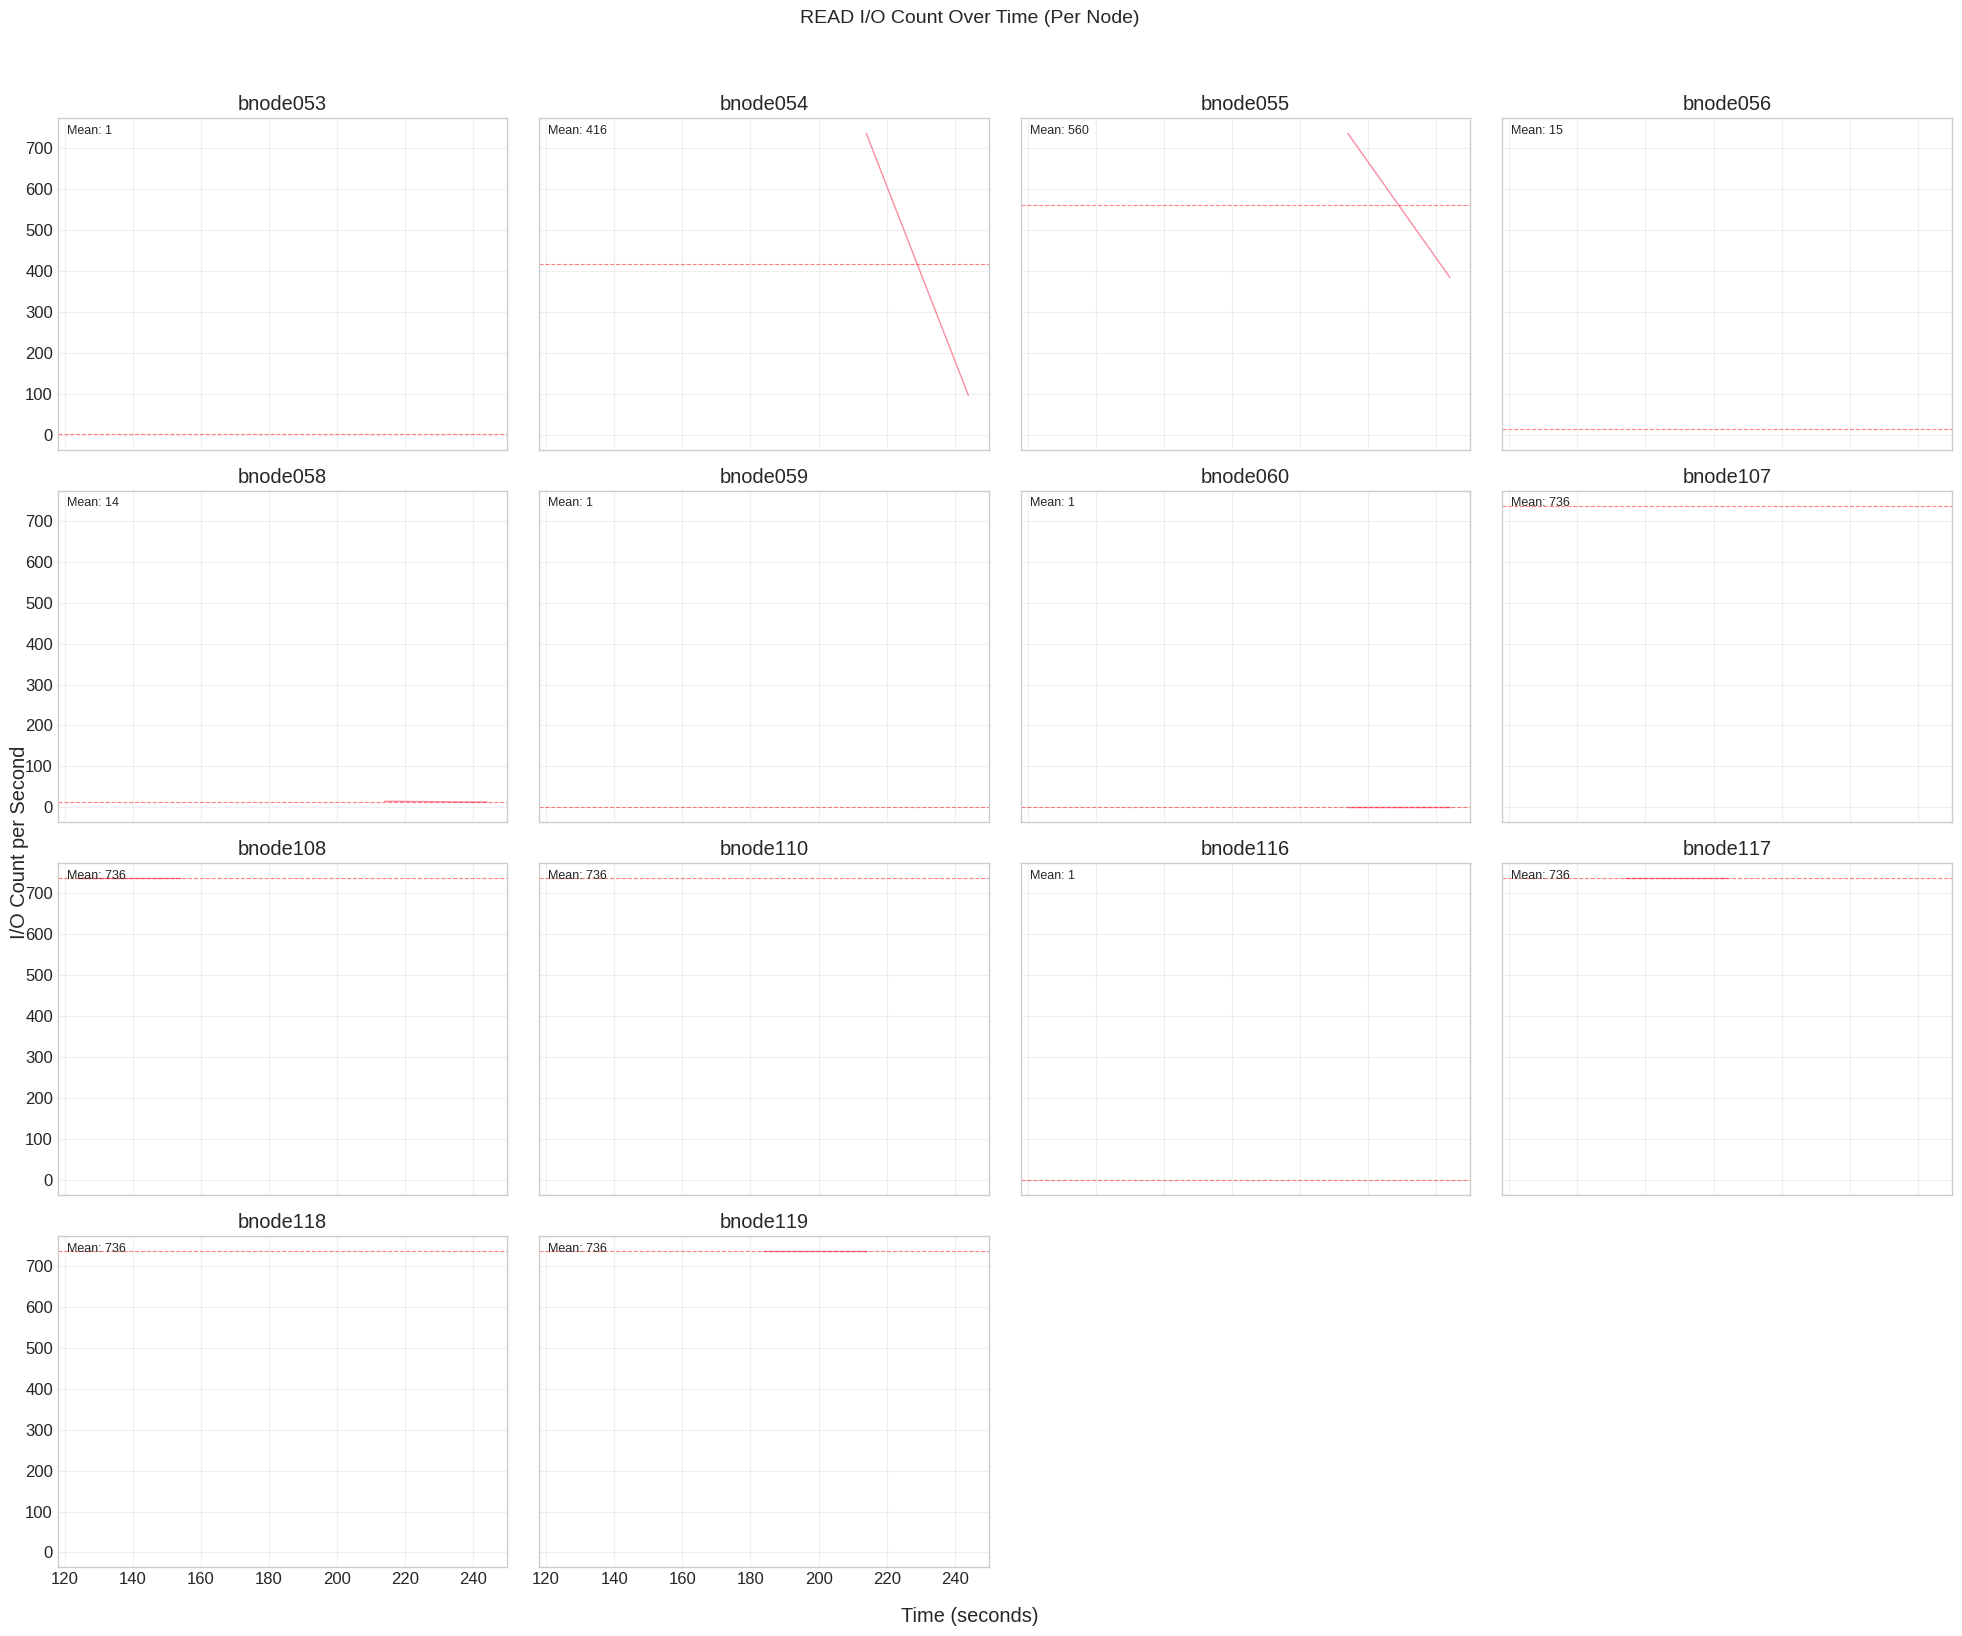

In [59]:
def plot_per_node_io_count(data, op_name, filename):
    if len(data) == 0:
        print(f"No {op_name} data")
        return
    
    # Aggregate by time bucket and node
    node_time_stats = data.groupby(['time_bucket', 'node']).size().reset_index(name='io_count')
    
    nodes = sorted(data['node'].unique())
    n_nodes = len(nodes)
    
    n_cols = 4
    n_rows = (n_nodes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, node in enumerate(nodes):
        ax = axes[i]
        node_data = node_time_stats[node_time_stats['node'] == node]
        
        ax.plot(node_data['time_bucket'], node_data['io_count'], linewidth=1, alpha=0.8)
        ax.set_title(f'{node}')
        ax.grid(True, alpha=0.3)
        
        mean_cnt = node_data['io_count'].mean()
        ax.axhline(y=mean_cnt, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        ax.text(0.02, 0.98, f'Mean: {mean_cnt:.0f}', transform=ax.transAxes, fontsize=9, va='top')
    
    for i in range(n_nodes, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'{op_name} I/O Count Over Time (Per Node)', fontsize=14, y=1.02)
    fig.supxlabel('Time (seconds)')
    fig.supylabel('I/O Count per Second')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_timing is not None:
    df_timing_write = df_timing[df_timing['op'] == 'WRITE']
    df_timing_read = df_timing[df_timing['op'] == 'READ']
    plot_per_node_io_count(df_timing_write, 'WRITE', 'io_timing_write_count_per_node.png')
    plot_per_node_io_count(df_timing_read, 'READ', 'io_timing_read_count_per_node.png')

## 2.6 Per-Node Statistics Summary

In [60]:
# Per-node summary statistics
if df_timing is not None:
    node_stats = df_timing.groupby(['node', 'op']).agg({
        'bandwidth_mib_s': ['mean', 'median', 'std', 'min', 'max', 'count'],
        'elapsed_ms': ['mean', 'median'],
        'bytes': 'sum'
    }).reset_index()
    node_stats.columns = ['node', 'op', 'bw_mean', 'bw_median', 'bw_std', 'bw_min', 'bw_max', 'count', 'latency_mean', 'latency_median', 'total_bytes']
    node_stats['total_gib'] = node_stats['total_bytes'] / (1024**3)

    print("=== WRITE per Node ===")
    write_node_stats = node_stats[node_stats['op'] == 'WRITE'].sort_values('node')
    print(write_node_stats[['node', 'count', 'total_gib', 'bw_mean', 'bw_median', 'latency_mean']].to_string(index=False))

    print("\n=== READ per Node ===")
    read_node_stats = node_stats[node_stats['op'] == 'READ'].sort_values('node')
    print(read_node_stats[['node', 'count', 'total_gib', 'bw_mean', 'bw_median', 'latency_mean']].to_string(index=False))

=== WRITE per Node ===
    node  count  total_gib     bw_mean  bw_median  latency_mean
bnode053     16   0.015625   99.427500     99.500     10.057816
bnode054   1450   1.416016  302.372710     82.555     16.270159
bnode055    744   0.726562  129.448145     15.205     70.012137
bnode056     57   0.055664  472.004211     99.160      9.195896
bnode058     35   0.034180  646.615714     99.570      8.786891
bnode059     31   0.030273 1890.142258     99.410      7.256705
bnode060      7   0.006836   99.577143     99.590     10.042556
bnode061      3   0.002930   98.970000     98.730     10.104120
bnode063      2   0.001953   99.790000     99.790     10.021240
bnode107    743   0.725586  129.292261     15.670     65.575097
bnode108   1464   1.429688   92.685758     27.085     45.733856
bnode110   1392   1.359375  291.115273     81.375     34.021644
bnode116      7   0.006836   99.324286     99.410     10.068270
bnode117    803   0.784180  257.884496     33.120     41.835705
bnode118   1388  

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (16,) and arg 1 with shape (14,).

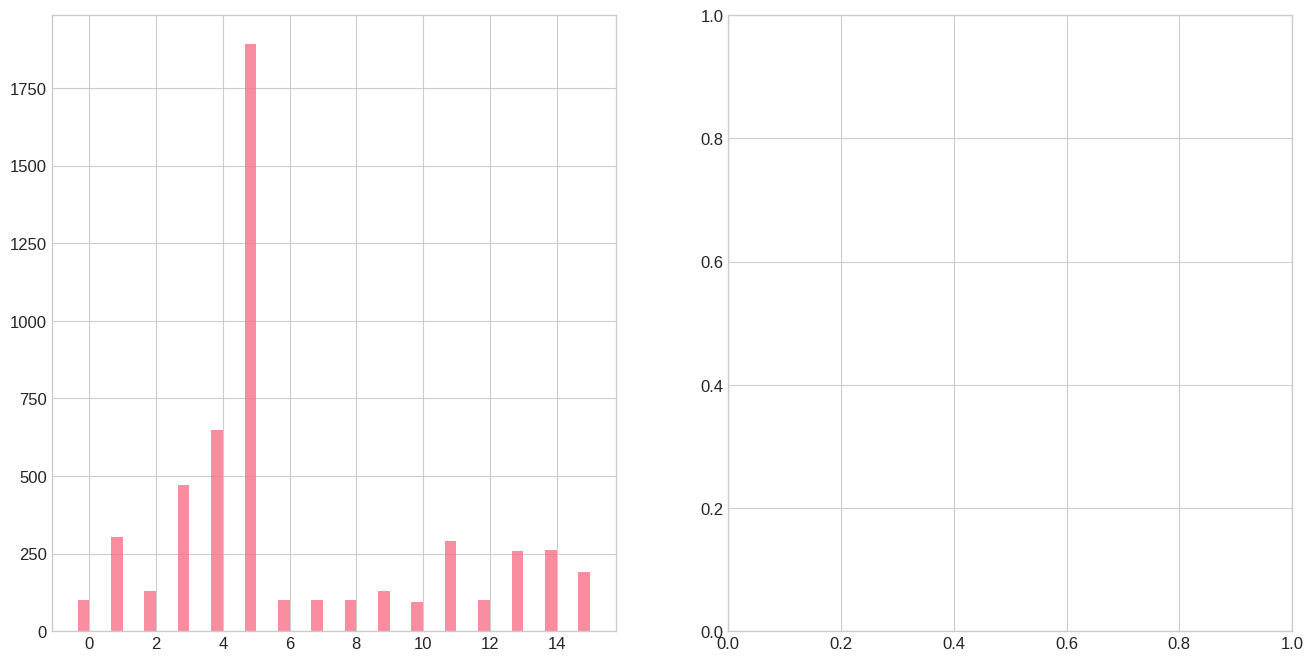

In [61]:
# Bar chart comparison
if df_timing is not None:
    node_stats = df_timing.groupby(['node', 'op']).agg({
        'bandwidth_mib_s': 'mean',
        'elapsed_ms': 'mean'
    }).reset_index()
    node_stats.columns = ['node', 'op', 'bw_mean', 'latency_mean']
    
    write_node_stats = node_stats[node_stats['op'] == 'WRITE'].sort_values('node')
    read_node_stats = node_stats[node_stats['op'] == 'READ'].sort_values('node')
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Mean bandwidth per node
    ax = axes[0]
    x = np.arange(len(write_node_stats))
    width = 0.35

    if len(write_node_stats) > 0:
        ax.bar(x - width/2, write_node_stats['bw_mean'], width, label='WRITE', alpha=0.8)
    if len(read_node_stats) > 0:
        ax.bar(x + width/2, read_node_stats['bw_mean'], width, label='READ', alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(write_node_stats['node'] if len(write_node_stats) > 0 else read_node_stats['node'], rotation=45, ha='right')
    ax.set_xlabel('Node')
    ax.set_ylabel('Mean Bandwidth (MiB/s)')
    ax.set_title('Mean I/O Bandwidth per Node')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Mean latency per node
    ax = axes[1]
    if len(write_node_stats) > 0:
        ax.bar(x - width/2, write_node_stats['latency_mean'], width, label='WRITE', alpha=0.8)
    if len(read_node_stats) > 0:
        ax.bar(x + width/2, read_node_stats['latency_mean'], width, label='READ', alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(write_node_stats['node'] if len(write_node_stats) > 0 else read_node_stats['node'], rotation=45, ha='right')
    ax.set_xlabel('Node')
    ax.set_ylabel('Mean Latency (ms)')
    ax.set_title('Mean I/O Latency per Node')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_timing_per_node_summary.png', dpi=150)
    plt.show()

## 2.7 Comparison: WRITE vs READ

In [ ]:
# I/O timing comparison
if df_timing is not None:
    print("=" * 80)
    print("I/O Timing Comparison: WRITE vs READ")
    print("=" * 80)

    df_timing_write = df_timing[df_timing['op'] == 'WRITE']
    df_timing_read = df_timing[df_timing['op'] == 'READ']

    if len(df_timing_write) > 0:
        print(f"\nWRITE:")
        print(f"  Total I/O count: {len(df_timing_write):,}")
        print(f"  Total bytes: {df_timing_write['bytes'].sum() / (1024**3):.2f} GiB")
        print(f"  Mean bandwidth: {df_timing_write['bandwidth_mib_s'].mean():.2f} MiB/s")
        print(f"  Mean latency: {df_timing_write['elapsed_ms'].mean():.2f} ms")
        print(f"  P50 latency: {df_timing_write['elapsed_ms'].quantile(0.50):.2f} ms")
        print(f"  P99 latency: {df_timing_write['elapsed_ms'].quantile(0.99):.2f} ms")

    if len(df_timing_read) > 0:
        print(f"\nREAD:")
        print(f"  Total I/O count: {len(df_timing_read):,}")
        print(f"  Total bytes: {df_timing_read['bytes'].sum() / (1024**3):.2f} GiB")
        print(f"  Mean bandwidth: {df_timing_read['bandwidth_mib_s'].mean():.2f} MiB/s")
        print(f"  Mean latency: {df_timing_read['elapsed_ms'].mean():.2f} ms")
        print(f"  P50 latency: {df_timing_read['elapsed_ms'].quantile(0.50):.2f} ms")
        print(f"  P99 latency: {df_timing_read['elapsed_ms'].quantile(0.99):.2f} ms")

    if len(df_timing_write) > 0 and len(df_timing_read) > 0:
        print(f"\nComparison:")
        print(f"  I/O count ratio (WRITE/READ): {len(df_timing_write)/len(df_timing_read):.2f}x")
        print(f"  Bandwidth ratio (WRITE/READ): {df_timing_write['bandwidth_mib_s'].mean()/df_timing_read['bandwidth_mib_s'].mean():.2f}x")
        print(f"  Latency ratio (READ/WRITE): {df_timing_read['elapsed_ms'].mean()/df_timing_write['elapsed_ms'].mean():.2f}x")
        
        if df_timing_read['bandwidth_mib_s'].mean() < df_timing_write['bandwidth_mib_s'].mean() * 0.5:
            print("\n*** WARNING: READ bandwidth is significantly lower than WRITE ***")
            print("This suggests disk I/O is a bottleneck for READ operations.")

---
# Part 3: Node Transfer Analysis

Analyzes load distribution across nodes over time.

## Data Source
- `node_transfer_aggregated.csv`: Aggregated transfer data per second, per client, per target node

In [ ]:
# Load node transfer data
df_transfer = load_csv_if_exists(RESULTS_DIR / 'node_transfer_aggregated.csv', 'node_transfer_aggregated.csv')

if df_transfer is not None:
    df_transfer['time_relative'] = df_transfer['time_bucket'] - df_transfer['time_bucket'].min()
    df_transfer['total_gib'] = df_transfer['total_bytes'] / (1024**3)
    
    print(f"\nTime range: {df_transfer['time_bucket'].min()} - {df_transfer['time_bucket'].max()} (duration: {df_transfer['time_relative'].max()}s)")
    print(f"Operations: {df_transfer['op'].unique()}")
    print(f"Target nodes: {sorted(df_transfer['target_node'].unique())}")
    print(f"Client nodes: {sorted(df_transfer['client_node'].unique())}")

## 3.1 Overall Throughput Over Time

In [ ]:
# Overall throughput over time
if df_transfer is not None:
    throughput_by_time = df_transfer.groupby(['time_relative', 'op'])['total_gib'].sum().unstack(fill_value=0)

    fig, ax = plt.subplots(figsize=(16, 6))

    if 'WRITE' in throughput_by_time.columns:
        ax.plot(throughput_by_time.index, throughput_by_time['WRITE'], label='WRITE', linewidth=1.5, alpha=0.8)
    if 'READ' in throughput_by_time.columns:
        ax.plot(throughput_by_time.index, throughput_by_time['READ'], label='READ', linewidth=1.5, alpha=0.8)

    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title('Overall Throughput Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'throughput_over_time.png', dpi=150)
    plt.show()

## 3.2 Per-Target-Node Throughput Over Time

In [ ]:
def plot_per_target_node_throughput(data, title, filename):
    """Plot throughput per target node over time"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate by time and target node
    node_throughput = data.groupby(['time_relative', 'target_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Sort columns naturally (node_0, node_1, ..., node_15)
    sorted_cols = sorted(node_throughput.columns, key=lambda x: int(x.split('_')[1]) if '_' in x else x)
    node_throughput = node_throughput[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(node_throughput.columns)))
    
    for i, col in enumerate(node_throughput.columns):
        ax.plot(node_throughput.index, node_throughput[col], 
                label=col, linewidth=1, alpha=0.7, color=colors[i])
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_transfer is not None:
    df_transfer_write = df_transfer[df_transfer['op'] == 'WRITE']
    df_transfer_read = df_transfer[df_transfer['op'] == 'READ']
    
    plot_per_target_node_throughput(df_transfer_write, 'WRITE: Per-Target-Node Throughput Over Time', 'write_per_node_throughput.png')
    plot_per_target_node_throughput(df_transfer_read, 'READ: Per-Target-Node Throughput Over Time', 'read_per_node_throughput.png')

## 3.3 Stacked Area Chart - Load Distribution

In [ ]:
def plot_stacked_area(data, title, filename):
    """Plot stacked area chart showing load distribution"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate by time and target node
    node_throughput = data.groupby(['time_relative', 'target_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Sort columns naturally
    sorted_cols = sorted(node_throughput.columns, key=lambda x: int(x.split('_')[1]) if '_' in x else x)
    node_throughput = node_throughput[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(node_throughput.columns)))
    
    ax.stackplot(node_throughput.index, 
                 [node_throughput[col] for col in node_throughput.columns],
                 labels=node_throughput.columns,
                 colors=colors,
                 alpha=0.8)
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_transfer is not None:
    df_transfer_write = df_transfer[df_transfer['op'] == 'WRITE']
    df_transfer_read = df_transfer[df_transfer['op'] == 'READ']
    
    plot_stacked_area(df_transfer_write, 'WRITE: Load Distribution Across Nodes', 'write_load_distribution.png')
    plot_stacked_area(df_transfer_read, 'READ: Load Distribution Across Nodes', 'read_load_distribution.png')

## 3.4 Per-Client-Node Throughput

In [ ]:
def plot_per_client_throughput(data, title, filename):
    """Plot throughput per client node over time"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate by time and client node
    client_throughput = data.groupby(['time_relative', 'client_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Sort columns
    sorted_cols = sorted(client_throughput.columns)
    client_throughput = client_throughput[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(client_throughput.columns)))
    
    for i, col in enumerate(client_throughput.columns):
        ax.plot(client_throughput.index, client_throughput[col], 
                label=col, linewidth=1, alpha=0.7, color=colors[i])
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_transfer is not None:
    df_transfer_write = df_transfer[df_transfer['op'] == 'WRITE']
    df_transfer_read = df_transfer[df_transfer['op'] == 'READ']
    
    plot_per_client_throughput(df_transfer_write, 'WRITE: Per-Client Throughput Over Time', 'write_per_client_throughput.png')
    plot_per_client_throughput(df_transfer_read, 'READ: Per-Client Throughput Over Time', 'read_per_client_throughput.png')

## 3.5 Heatmap - Node Load Over Time

In [ ]:
def plot_heatmap(data, title, filename, time_bin=5):
    """Plot heatmap of node load over time (binned)"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Bin time into larger intervals for clearer heatmap
    data = data.copy()
    data['time_bin'] = (data['time_relative'] // time_bin) * time_bin
    
    # Aggregate by time bin and target node
    heatmap_data = data.groupby(['time_bin', 'target_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Sort columns naturally
    sorted_cols = sorted(heatmap_data.columns, key=lambda x: int(x.split('_')[1]) if '_' in x else x)
    heatmap_data = heatmap_data[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    im = ax.imshow(heatmap_data.T, aspect='auto', cmap='YlOrRd',
                   extent=[heatmap_data.index.min(), heatmap_data.index.max(), 
                           len(heatmap_data.columns)-0.5, -0.5])
    
    ax.set_xlabel(f'Time (seconds, {time_bin}s bins)')
    ax.set_ylabel('Target Node')
    ax.set_title(title)
    ax.set_yticks(range(len(heatmap_data.columns)))
    ax.set_yticklabels(heatmap_data.columns)
    
    cbar = plt.colorbar(im, ax=ax, label='Throughput (GiB)')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150)
    plt.show()

if df_transfer is not None:
    df_transfer_write = df_transfer[df_transfer['op'] == 'WRITE']
    df_transfer_read = df_transfer[df_transfer['op'] == 'READ']
    
    plot_heatmap(df_transfer_write, 'WRITE: Node Load Heatmap', 'write_heatmap.png', time_bin=5)
    plot_heatmap(df_transfer_read, 'READ: Node Load Heatmap', 'read_heatmap.png', time_bin=5)

## 3.6 Load Imbalance Analysis

In [ ]:
def analyze_load_imbalance(data, title):
    """Analyze load imbalance across nodes over time"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate by time and target node
    node_throughput = data.groupby(['time_relative', 'target_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Calculate per-second statistics
    stats = pd.DataFrame({
        'mean': node_throughput.mean(axis=1),
        'std': node_throughput.std(axis=1),
        'min': node_throughput.min(axis=1),
        'max': node_throughput.max(axis=1),
        'total': node_throughput.sum(axis=1)
    })
    stats['cv'] = stats['std'] / stats['mean'] * 100  # Coefficient of variation (%)
    stats['imbalance'] = (stats['max'] - stats['min']) / stats['mean'] * 100
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Total throughput
    ax = axes[0, 0]
    ax.plot(stats.index, stats['total'], linewidth=1.5)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Total Throughput (GiB/s)')
    ax.set_title(f'{title}: Total Throughput')
    ax.grid(True, alpha=0.3)
    
    # Min/Max/Mean per node
    ax = axes[0, 1]
    ax.fill_between(stats.index, stats['min'], stats['max'], alpha=0.3, label='Min-Max Range')
    ax.plot(stats.index, stats['mean'], linewidth=1.5, label='Mean', color='blue')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Per-Node Throughput (GiB/s)')
    ax.set_title(f'{title}: Per-Node Throughput Range')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Coefficient of Variation
    ax = axes[1, 0]
    ax.plot(stats.index, stats['cv'], linewidth=1.5, color='orange')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('CV (%)')
    ax.set_title(f'{title}: Coefficient of Variation (lower = more balanced)')
    ax.grid(True, alpha=0.3)
    
    # Imbalance percentage
    ax = axes[1, 1]
    ax.plot(stats.index, stats['imbalance'], linewidth=1.5, color='red')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Imbalance (%)')
    ax.set_title(f'{title}: Load Imbalance (max-min)/mean')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'{title.lower().replace(":", "").replace(" ", "_")}_imbalance.png', dpi=150)
    plt.show()
    
    # Print summary statistics
    print(f"\n{title} - Summary Statistics:")
    print(f"  Average total throughput: {stats['total'].mean():.2f} GiB/s")
    print(f"  Average per-node throughput: {stats['mean'].mean():.2f} GiB/s")
    print(f"  Average CV: {stats['cv'].mean():.2f}%")
    print(f"  Average imbalance: {stats['imbalance'].mean():.2f}%")
    print(f"  Max imbalance: {stats['imbalance'].max():.2f}%")

if df_transfer is not None:
    df_transfer_write = df_transfer[df_transfer['op'] == 'WRITE']
    df_transfer_read = df_transfer[df_transfer['op'] == 'READ']
    
    analyze_load_imbalance(df_transfer_write, 'WRITE')
    analyze_load_imbalance(df_transfer_read, 'READ')

## 3.7 Transfer Count Analysis

In [ ]:
def plot_transfer_counts(data, title, filename):
    """Plot transfer counts per node over time"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate transfer counts by time and target node
    count_data = data.groupby(['time_relative', 'target_node'])['transfer_count'].sum().unstack(fill_value=0)
    
    # Sort columns naturally
    sorted_cols = sorted(count_data.columns, key=lambda x: int(x.split('_')[1]) if '_' in x else x)
    count_data = count_data[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(count_data.columns)))
    
    ax.stackplot(count_data.index, 
                 [count_data[col] for col in count_data.columns],
                 labels=count_data.columns,
                 colors=colors,
                 alpha=0.8)
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Transfer Count')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_transfer is not None:
    df_transfer_write = df_transfer[df_transfer['op'] == 'WRITE']
    df_transfer_read = df_transfer[df_transfer['op'] == 'READ']
    
    plot_transfer_counts(df_transfer_write, 'WRITE: Transfer Count Distribution', 'write_transfer_counts.png')
    plot_transfer_counts(df_transfer_read, 'READ: Transfer Count Distribution', 'read_transfer_counts.png')

## 3.8 Summary Table

In [ ]:
# Total bytes per target node
if df_transfer is not None:
    summary = df_transfer.groupby(['op', 'target_node']).agg({
        'total_bytes': 'sum',
        'transfer_count': 'sum'
    }).reset_index()

    summary['total_gib'] = summary['total_bytes'] / (1024**3)
    summary['avg_transfer_size_mb'] = summary['total_bytes'] / summary['transfer_count'] / (1024**2)

    print("=== Per-Node Summary ===")
    for op in ['WRITE', 'READ']:
        print(f"\n{op}:")
        op_data = summary[summary['op'] == op].sort_values('target_node')
        print(op_data[['target_node', 'total_gib', 'transfer_count', 'avg_transfer_size_mb']].to_string(index=False))

---
# Summary

Analysis completed. Check the generated PNG files in the results directory.

In [ ]:
print("=" * 80)
print("Analysis Complete")
print("=" * 80)
print(f"\nResults directory: {RESULTS_DIR}")
print("\nGenerated files:")
for f in sorted(RESULTS_DIR.glob('*.png')):
    print(f"  - {f.name}")